Import important parameter

In [1]:
inputsize = 49
e = 0.0008

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.7628255998412654


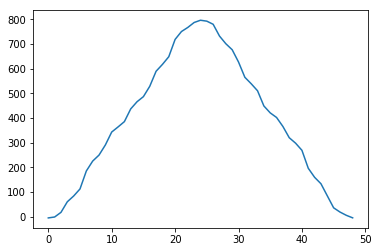

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 666.4550322373263


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.8432447155100014
Iteration 200/4000
Upper bound estimation = 0.8249332660285825
Iteration 300/4000
Upper bound estimation = 0.8065406135922608
Iteration 400/4000
Upper bound estimation = 0.7886016563849761
Iteration 500/4000
Upper bound estimation = 0.79682194231613
Iteration 600/4000
Upper bound estimation = 0.7845671495452285
Iteration 700/4000
Upper bound estimation = 0.7702332208444811
Iteration 800/4000
Upper bound estimation = 0.7560961559153908
Iteration 900/4000
Upper bound estimation = 0.7590276632080302
Iteration 1000/4000
Upper bound estimation = 0.7561864336656279
Iteration 1100/4000
Upper bound estimation = 0.7208651120986823
Iteration 1200/4000
Upper bound estimation = 0.7310792573670537
Iteration 1300/4000
Upper bound estimation = 0.7101061558982302
Iteration 1400/4000
Upper bound estimation = 0.7010224884768901
Iteration 1500/4000
Upper bound estimation = 0.6901887687487829
Iteration 1600/4000
Upper bound estimation = 0.6612

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.3374042984065272


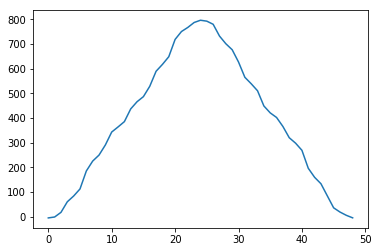

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 666.4550322373354


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11963715217403839
L = 0.03
rho = 0.1212019812338857
L = 0.04
rho = 0.12337487083058829
L = 0.05
rho = 0.12585377797498792
L = 0.060000000000000005
rho = 0.12847534243035227
L = 0.07
rho = 0.13116308758634174
L = 0.08
rho = 0.13388104015845068
L = 0.09
rho = 0.13661120636332014
L = 0.09999999999999999
rho = 0.13934389466431737
L = 0.10999999999999999
rho = 0.14207349453154133
L = 0.11999999999999998
rho = 0.1447965305113533
L = 0.12999999999999998
rho = 0.14751070918395714
L = 0.13999999999999999
rho = 0.15021442622634537
L = 0.15
rho = 0.1529064992945636
L = 0.16
rho = 0.1555860173693016
L = 0.17
rho = 0.1582522527032684
L = 0.18000000000000002
rho = 0.16090460760411365
L = 0.19000000000000003
rho = 0.16354258118564574
L = 0.20000000000000004
rho = 0.16616574787070937
L = 0.21000000000000005
rho = 0.1687737429808413
L = 0.22000000000000006
rho = 0.17136625270158823
L = 0.23000000000000007
rho = 0.17394300681447677
L = 0.24000000000000007
rho = 0.1

the 54 steps
rho = 0.3281404903944972
the 55 steps
rho = 0.328135928311627
the 56 steps
rho = 0.32813137678232923
the 57 steps
rho = 0.32812683571164386
the 58 steps
rho = 0.3281223050055813
the 59 steps
rho = 0.3281177845711127
the 60 steps
rho = 0.3281132743161655
the 61 steps
rho = 0.328108774149602
the 62 steps
rho = 0.32810428398121977
the 63 steps
rho = 0.328099803721734
the 64 steps
rho = 0.3280953332827714
the 65 steps
rho = 0.32809087257685715
the 66 steps
rho = 0.32808642151741013
the 67 steps
rho = 0.3280819800187271
the 68 steps
rho = 0.32807754799597766
the 69 steps
rho = 0.32807312536519223
the 70 steps
rho = 0.32806871204325333
the 71 steps
rho = 0.3280643079478896
the 72 steps
rho = 0.3280599129976585
the 73 steps
rho = 0.3280555271119471
the 74 steps
rho = 0.32805115021095316
the 75 steps
rho = 0.3280467822156857
the 76 steps
rho = 0.32804242304795106
the 77 steps
rho = 0.32803807263034407
the 78 steps
rho = 0.3280337308862414
the 79 steps
rho = 0.32802939773979156
the

the 217 steps
rho = 0.3274891724378768
the 218 steps
rho = 0.3274855475293044
the 219 steps
rho = 0.3274819254788069
the 220 steps
rho = 0.3274783062668445
the 221 steps
rho = 0.32747468987405326
the 222 steps
rho = 0.32747107628124505
the 223 steps
rho = 0.3274674654694069
the 224 steps
rho = 0.3274638574196965
the 225 steps
rho = 0.3274602521134406
the 226 steps
rho = 0.32745664953213827
the 227 steps
rho = 0.3274530496574558
the 228 steps
rho = 0.32744945247122104
the 229 steps
rho = 0.32744585795542513
the 230 steps
rho = 0.3274422660922265
the 231 steps
rho = 0.32743867686394196
the 232 steps
rho = 0.3274350902530452
the 233 steps
rho = 0.32743150624217
the 234 steps
rho = 0.3274279248141056
the 235 steps
rho = 0.32742434595179315
the 236 steps
rho = 0.3274207696383295
the 237 steps
rho = 0.32741719585696244
the 238 steps
rho = 0.3274136245910906
the 239 steps
rho = 0.32741005582425564
the 240 steps
rho = 0.32740648954015483
the 241 steps
rho = 0.32740292572262275
the 242 steps
rh

the 380 steps
rho = 0.32692599635158825
the 381 steps
rho = 0.32692266803871906
the 382 steps
rho = 0.32691934087945906
the 383 steps
rho = 0.32691601486887856
the 384 steps
rho = 0.32691269000209394
the 385 steps
rho = 0.32690936627424927
the 386 steps
rho = 0.32690604368053106
the 387 steps
rho = 0.32690272221616395
the 388 steps
rho = 0.32689940187640376
the 389 steps
rho = 0.3268960826565464
the 390 steps
rho = 0.3268927645519235
the 391 steps
rho = 0.32688944755789906
the 392 steps
rho = 0.3268861316698738
the 393 steps
rho = 0.32688281688328363
the 394 steps
rho = 0.32687950319359815
the 395 steps
rho = 0.32687619059632217
the 396 steps
rho = 0.3268728790869925
the 397 steps
rho = 0.3268695686611805
the 398 steps
rho = 0.3268662593144919
the 399 steps
rho = 0.32686295104256236
the 400 steps
rho = 0.32685964384106364
the 401 steps
rho = 0.3268563377056946
the 402 steps
rho = 0.32685303263219323
the 403 steps
rho = 0.32684972861632194
the 404 steps
rho = 0.32684642565388206
the 405

the 551 steps
rho = 0.3263705762845826
the 552 steps
rho = 0.3263673956719657
the 553 steps
rho = 0.32636421572222146
the 554 steps
rho = 0.3263610364337625
the 555 steps
rho = 0.3263578578050014
the 556 steps
rho = 0.32635467983436733
the 557 steps
rho = 0.32635150252029266
the 558 steps
rho = 0.32634832586122164
the 559 steps
rho = 0.3263451498556025
the 560 steps
rho = 0.3263419745018974
the 561 steps
rho = 0.32633879979857155
the 562 steps
rho = 0.3263356257441055
the 563 steps
rho = 0.3263324523369769
the 564 steps
rho = 0.3263292795756812
the 565 steps
rho = 0.32632610745871793
the 566 steps
rho = 0.32632293598459394
the 567 steps
rho = 0.32631976515182426
the 568 steps
rho = 0.32631659495893245
the 569 steps
rho = 0.32631342540445146
the 570 steps
rho = 0.3263102564869153
the 571 steps
rho = 0.32630708820487553
the 572 steps
rho = 0.32630392055688207
the 573 steps
rho = 0.3263007535414981
the 574 steps
rho = 0.32629758715729007
the 575 steps
rho = 0.32629442140283643
the 576 ste

the 708 steps
rho = 0.32587849901462534
the 709 steps
rho = 0.32587540713014923
the 710 steps
rho = 0.3258723157322708
the 711 steps
rho = 0.32586922482019254
the 712 steps
rho = 0.3258661343931197
the 713 steps
rho = 0.3258630444502586
the 714 steps
rho = 0.325859954990819
the 715 steps
rho = 0.3258568660140168
the 716 steps
rho = 0.32585377751906536
the 717 steps
rho = 0.32585068950518264
the 718 steps
rho = 0.3258476019715915
the 719 steps
rho = 0.32584451491751504
the 720 steps
rho = 0.3258414283421788
the 721 steps
rho = 0.32583834224481023
the 722 steps
rho = 0.32583525662464424
the 723 steps
rho = 0.3258321714809121
the 724 steps
rho = 0.32582908681285183
the 725 steps
rho = 0.3258260026197023
the 726 steps
rho = 0.3258229189007048
the 727 steps
rho = 0.3258198356551033
the 728 steps
rho = 0.32581675288214496
the 729 steps
rho = 0.32581367058107963
the 730 steps
rho = 0.32581058875115976
the 731 steps
rho = 0.32580750739163505
the 732 steps
rho = 0.32580442650176666
the 733 step

the 855 steps
rho = 0.3254288436426965
the 856 steps
rho = 0.3254258158968229
the 857 steps
rho = 0.3254227885430073
the 858 steps
rho = 0.3254197615807298
the 859 steps
rho = 0.325416735009469
the 860 steps
rho = 0.32541370882870235
the 861 steps
rho = 0.32541068303791404
the 862 steps
rho = 0.3254076576365851
the 863 steps
rho = 0.3254046326241986
the 864 steps
rho = 0.32540160800024237
the 865 steps
rho = 0.3253985837641995
the 866 steps
rho = 0.32539555991555713
the 867 steps
rho = 0.32539253645380717
the 868 steps
rho = 0.32538951337843747
the 869 steps
rho = 0.32538649068893954
the 870 steps
rho = 0.32538346838480336
the 871 steps
rho = 0.3253804464655272
the 872 steps
rho = 0.3253774249306
the 873 steps
rho = 0.32537440377952254
the 874 steps
rho = 0.3253713830117892
the 875 steps
rho = 0.325368362626897
the 876 steps
rho = 0.32536534262434846
the 877 steps
rho = 0.32536232300364337
the 878 steps
rho = 0.3253593037642807
the 879 steps
rho = 0.32535628490576474
the 880 steps
rho 

the 1009 steps
rho = 0.3249669029081599
the 1010 steps
rho = 0.324963930031663
the 1011 steps
rho = 0.3249609574789679
the 1012 steps
rho = 0.3249579852497
the 1013 steps
rho = 0.3249550133434805
the 1014 steps
rho = 0.32495204175993636
the 1015 steps
rho = 0.3249490704986915
the 1016 steps
rho = 0.3249460995593744
the 1017 steps
rho = 0.32494312894160915
the 1018 steps
rho = 0.3249401586450236
the 1019 steps
rho = 0.32493718866924864
the 1020 steps
rho = 0.3249342190139104
the 1021 steps
rho = 0.32493124967863934
the 1022 steps
rho = 0.3249282806630689
the 1023 steps
rho = 0.3249253119668255
the 1024 steps
rho = 0.32492234358954303
the 1025 steps
rho = 0.3249193755308543
the 1026 steps
rho = 0.3249164077903917
the 1027 steps
rho = 0.32491344036778974
the 1028 steps
rho = 0.3249104732626827
the 1029 steps
rho = 0.3249075064747051
the 1030 steps
rho = 0.3249045400034937
the 1031 steps
rho = 0.3249015738486857
the 1032 steps
rho = 0.3248986080099184
the 1033 steps
rho = 0.324895642486826

the 1176 steps
rho = 0.32447465405680664
the 1177 steps
rho = 0.3244717305224459
the 1178 steps
rho = 0.32446880725754773
the 1179 steps
rho = 0.3244658842618305
the 1180 steps
rho = 0.3244629615350174
the 1181 steps
rho = 0.3244600390768277
the 1182 steps
rho = 0.32445711688698076
the 1183 steps
rho = 0.32445419496519917
the 1184 steps
rho = 0.32445127331120555
the 1185 steps
rho = 0.32444835192472105
the 1186 steps
rho = 0.3244454308054667
the 1187 steps
rho = 0.32444250995316926
the 1188 steps
rho = 0.3244395893675502
the 1189 steps
rho = 0.32443666904833557
the 1190 steps
rho = 0.32443374899524696
the 1191 steps
rho = 0.32443082920800975
the 1192 steps
rho = 0.3244279096863543
the 1193 steps
rho = 0.3244249904300004
the 1194 steps
rho = 0.32442207143867613
the 1195 steps
rho = 0.32441915271211086
the 1196 steps
rho = 0.3244162342500295
the 1197 steps
rho = 0.32441331605215873
the 1198 steps
rho = 0.3244103981182287
the 1199 steps
rho = 0.32440748044796863
the 1200 steps
rho = 0.324

the 1354 steps
rho = 0.32395826794388827
the 1355 steps
rho = 0.32395538834513904
the 1356 steps
rho = 0.3239525089723671
the 1357 steps
rho = 0.3239496298253592
the 1358 steps
rho = 0.3239467509039057
the 1359 steps
rho = 0.32394387220779536
the 1360 steps
rho = 0.32394099373681334
the 1361 steps
rho = 0.323938115490754
the 1362 steps
rho = 0.32393523746940167
the 1363 steps
rho = 0.32393235967255224
the 1364 steps
rho = 0.3239294820999902
the 1365 steps
rho = 0.3239266047515078
the 1366 steps
rho = 0.32392372762689764
the 1367 steps
rho = 0.32392085072594895
the 1368 steps
rho = 0.32391797404845496
the 1369 steps
rho = 0.3239150975942036
the 1370 steps
rho = 0.32391222136298986
the 1371 steps
rho = 0.32390934535460836
the 1372 steps
rho = 0.32390646956884644
the 1373 steps
rho = 0.32390359400550073
the 1374 steps
rho = 0.3239007186643636
the 1375 steps
rho = 0.32389784354522844
the 1376 steps
rho = 0.3238949686478896
the 1377 steps
rho = 0.32389209397213875
the 1378 steps
rho = 0.323

the 1507 steps
rho = 0.3235201994738883
the 1508 steps
rho = 0.323517352156954
the 1509 steps
rho = 0.3235145050369085
the 1510 steps
rho = 0.3235116581135838
the 1511 steps
rho = 0.3235088113868062
the 1512 steps
rho = 0.32350596485640953
the 1513 steps
rho = 0.32350311852222463
the 1514 steps
rho = 0.32350027238407986
the 1515 steps
rho = 0.3234974264418089
the 1516 steps
rho = 0.3234945806952433
the 1517 steps
rho = 0.3234917351442129
the 1518 steps
rho = 0.32348888978854995
the 1519 steps
rho = 0.32348604462808755
the 1520 steps
rho = 0.3234831996626573
the 1521 steps
rho = 0.32348035489209254
the 1522 steps
rho = 0.32347751031622557
the 1523 steps
rho = 0.32347466593489105
the 1524 steps
rho = 0.3234718217479204
the 1525 steps
rho = 0.3234689777551467
the 1526 steps
rho = 0.3234661339564047
the 1527 steps
rho = 0.32346329035152876
the 1528 steps
rho = 0.32346044694035286
the 1529 steps
rho = 0.3234576037227118
the 1530 steps
rho = 0.3234547606984399
the 1531 steps
rho = 0.32345191

the 1657 steps
rho = 0.3230952130232542
the 1658 steps
rho = 0.3230923934626446
the 1659 steps
rho = 0.3230895740758551
the 1660 steps
rho = 0.323086754862746
the 1661 steps
rho = 0.3230839358231789
the 1662 steps
rho = 0.32308111695701697
the 1663 steps
rho = 0.32307829826412027
the 1664 steps
rho = 0.32307547974435025
the 1665 steps
rho = 0.32307266139757107
the 1666 steps
rho = 0.3230698432236429
the 1667 steps
rho = 0.32306702522242947
the 1668 steps
rho = 0.32306420739379305
the 1669 steps
rho = 0.32306138973759563
the 1670 steps
rho = 0.32305857225370216
the 1671 steps
rho = 0.32305575494197314
the 1672 steps
rho = 0.32305293780227506
the 1673 steps
rho = 0.32305012083446777
the 1674 steps
rho = 0.3230473040384181
the 1675 steps
rho = 0.32304448741398806
the 1676 steps
rho = 0.3230416709610431
the 1677 steps
rho = 0.3230388546794472
the 1678 steps
rho = 0.3230360385690644
the 1679 steps
rho = 0.3230332226297581
the 1680 steps
rho = 0.32303040686139617
the 1681 steps
rho = 0.32302

the 1826 steps
rho = 0.32262107075125007
the 1827 steps
rho = 0.32261827872915966
the 1828 steps
rho = 0.3226154868597749
the 1829 steps
rho = 0.32261269514297997
the 1830 steps
rho = 0.3226099035786657
the 1831 steps
rho = 0.32260711216672033
the 1832 steps
rho = 0.322604320907031
the 1833 steps
rho = 0.3226015297994868
the 1834 steps
rho = 0.32259873884397816
the 1835 steps
rho = 0.32259594804038855
the 1836 steps
rho = 0.3225931573886117
the 1837 steps
rho = 0.3225903668885329
the 1838 steps
rho = 0.32258757654004344
the 1839 steps
rho = 0.32258478634303256
the 1840 steps
rho = 0.32258199629738826
the 1841 steps
rho = 0.322579206403002
the 1842 steps
rho = 0.32257641665976017
the 1843 steps
rho = 0.3225736270675553
the 1844 steps
rho = 0.32257083762627486
the 1845 steps
rho = 0.3225680483358124
the 1846 steps
rho = 0.3225652591960546
the 1847 steps
rho = 0.32256247020689344
the 1848 steps
rho = 0.3225596813682186
the 1849 steps
rho = 0.32255689267992127
the 1850 steps
rho = 0.322554

the 1986 steps
rho = 0.32217621787911366
the 1987 steps
rho = 0.32217344894868327
the 1988 steps
rho = 0.32217068015460665
the 1989 steps
rho = 0.32216791149678997
the 1990 steps
rho = 0.3221651429751394
the 1991 steps
rho = 0.322162374589563
the 1992 steps
rho = 0.3221596063399687
the 1993 steps
rho = 0.3221568382262626
the 1994 steps
rho = 0.3221540702483552
the 1995 steps
rho = 0.32215130240615075
the 1996 steps
rho = 0.3221485346995593
the 1997 steps
rho = 0.3221457671284883
the 1998 steps
rho = 0.3221429996928445
the 1999 steps
rho = 0.3221402323925395
the 2000 steps
rho = 0.32213746522747655
the 2001 steps
rho = 0.3221346981975681
the 2002 steps
rho = 0.32213193130272016
the 2003 steps
rho = 0.3221291645428428
the 2004 steps
rho = 0.3221263979178441
the 2005 steps
rho = 0.3221236314276342
the 2006 steps
rho = 0.3221208650721193
the 2007 steps
rho = 0.3221180988512092
the 2008 steps
rho = 0.3221153327648146
the 2009 steps
rho = 0.3221125668128437
the 2010 steps
rho = 0.32210980099

the 2125 steps
rho = 0.32179260512901076
the 2126 steps
rho = 0.3217898543045979
the 2127 steps
rho = 0.3217871036045726
the 2128 steps
rho = 0.32178435302885616
the 2129 steps
rho = 0.3217816025773666
the 2130 steps
rho = 0.3217788522500269
the 2131 steps
rho = 0.32177610204675533
the 2132 steps
rho = 0.3217733519674756
the 2133 steps
rho = 0.32177060201210667
the 2134 steps
rho = 0.32176785218056864
the 2135 steps
rho = 0.3217651024727839
the 2136 steps
rho = 0.32176235288867283
the 2137 steps
rho = 0.3217596034281578
the 2138 steps
rho = 0.32175685409115895
the 2139 steps
rho = 0.32175410487759837
the 2140 steps
rho = 0.3217513557873963
the 2141 steps
rho = 0.3217486068204748
the 2142 steps
rho = 0.32174585797675537
the 2143 steps
rho = 0.3217431092561598
the 2144 steps
rho = 0.3217403606586104
the 2145 steps
rho = 0.3217376121840282
the 2146 steps
rho = 0.3217348638323348
the 2147 steps
rho = 0.3217321156034531
the 2148 steps
rho = 0.3217293674973061
the 2149 steps
rho = 0.32172661

the 2261 steps
rho = 0.32141960337133607
the 2262 steps
rho = 0.32141686876644143
the 2263 steps
rho = 0.32141413427584864
the 2264 steps
rho = 0.3214113998994906
the 2265 steps
rho = 0.3214086656372964
the 2266 steps
rho = 0.3214059314891972
the 2267 steps
rho = 0.3214031974551264
the 2268 steps
rho = 0.3214004635350114
the 2269 steps
rho = 0.3213977297287867
the 2270 steps
rho = 0.3213949960363839
the 2271 steps
rho = 0.32139226245773217
the 2272 steps
rho = 0.321389528992766
the 2273 steps
rho = 0.3213867956414148
the 2274 steps
rho = 0.32138406240361067
the 2275 steps
rho = 0.32138132927928714
the 2276 steps
rho = 0.32137859626837445
the 2277 steps
rho = 0.321375863370805
the 2278 steps
rho = 0.3213731305865096
the 2279 steps
rho = 0.321370397915424
the 2280 steps
rho = 0.321367665357475
the 2281 steps
rho = 0.32136493291259893
the 2282 steps
rho = 0.3213622005807272
the 2283 steps
rho = 0.321359468361792
the 2284 steps
rho = 0.321356736255725
the 2285 steps
rho = 0.321354004262458

the 2424 steps
rho = 0.32097532497396075
the 2425 steps
rho = 0.32097260813759676
the 2426 steps
rho = 0.32096989140517157
the 2427 steps
rho = 0.3209671747766229
the 2428 steps
rho = 0.320964458251891
the 2429 steps
rho = 0.3209617418309215
the 2430 steps
rho = 0.3209590255136536
the 2431 steps
rho = 0.3209563093000279
the 2432 steps
rho = 0.3209535931899888
the 2433 steps
rho = 0.3209508771834761
the 2434 steps
rho = 0.3209481612804327
the 2435 steps
rho = 0.32094544548079973
the 2436 steps
rho = 0.32094272978452054
the 2437 steps
rho = 0.3209400141915346
the 2438 steps
rho = 0.32093729870178833
the 2439 steps
rho = 0.32093458331521757
the 2440 steps
rho = 0.32093186803176993
the 2441 steps
rho = 0.3209291528513865
the 2442 steps
rho = 0.3209264377740074
the 2443 steps
rho = 0.320923722799578
the 2444 steps
rho = 0.3209210079280382
the 2445 steps
rho = 0.32091829315933146
the 2446 steps
rho = 0.3209155784933999
the 2447 steps
rho = 0.3209128639301884
the 2448 steps
rho = 0.3209101494

the 2566 steps
rho = 0.3205905482563226
the 2567 steps
rho = 0.3205878456183111
the 2568 steps
rho = 0.32058514307646213
the 2569 steps
rho = 0.3205824406307243
the 2570 steps
rho = 0.320579738281047
the 2571 steps
rho = 0.3205770360273796
the 2572 steps
rho = 0.32057433386966916
the 2573 steps
rho = 0.32057163180786785
the 2574 steps
rho = 0.3205689298419209
the 2575 steps
rho = 0.32056622797178136
the 2576 steps
rho = 0.32056352619739586
the 2577 steps
rho = 0.320560824518715
the 2578 steps
rho = 0.3205581229356875
the 2579 steps
rho = 0.32055542144826343
the 2580 steps
rho = 0.32055272005639013
the 2581 steps
rho = 0.32055001876002037
the 2582 steps
rho = 0.32054731755910176
the 2583 steps
rho = 0.32054461645358356
the 2584 steps
rho = 0.3205419154434161
the 2585 steps
rho = 0.3205392145285493
the 2586 steps
rho = 0.3205365137089307
the 2587 steps
rho = 0.32053381298451367
the 2588 steps
rho = 0.32053111235524623
the 2589 steps
rho = 0.3205284118210769
the 2590 steps
rho = 0.3205257

the 2737 steps
rho = 0.32012975461705145
the 2738 steps
rho = 0.3201270677173484
the 2739 steps
rho = 0.320124380905724
the 2740 steps
rho = 0.32012169418212855
the 2741 steps
rho = 0.32011900754652167
the 2742 steps
rho = 0.3201163209988599
the 2743 steps
rho = 0.3201136345390994
the 2744 steps
rho = 0.3201109481671951
the 2745 steps
rho = 0.3201082618831051
the 2746 steps
rho = 0.3201055756867852
the 2747 steps
rho = 0.3201028895781902
the 2748 steps
rho = 0.3201002035572816
the 2749 steps
rho = 0.32009751762401145
the 2750 steps
rho = 0.3200948317783385
the 2751 steps
rho = 0.3200921460202204
the 2752 steps
rho = 0.3200894603496095
the 2753 steps
rho = 0.3200867747664684
the 2754 steps
rho = 0.32008408927075066
the 2755 steps
rho = 0.32008140386241263
the 2756 steps
rho = 0.320078718541415
the 2757 steps
rho = 0.32007603330771084
the 2758 steps
rho = 0.32007334816125727
the 2759 steps
rho = 0.3200706631020143
the 2760 steps
rho = 0.32006797812993787
the 2761 steps
rho = 0.3200652932

the 2885 steps
rho = 0.3197330291422019
the 2886 steps
rho = 0.3197303548222819
the 2887 steps
rho = 0.319727680584372
the 2888 steps
rho = 0.3197250064284357
the 2889 steps
rho = 0.31972233235443537
the 2890 steps
rho = 0.3197196583623349
the 2891 steps
rho = 0.31971698445209207
the 2892 steps
rho = 0.3197143106236695
the 2893 steps
rho = 0.31971163687703025
the 2894 steps
rho = 0.31970896321213493
the 2895 steps
rho = 0.31970628962894654
the 2896 steps
rho = 0.3197036161274273
the 2897 steps
rho = 0.31970094270753757
the 2898 steps
rho = 0.3196982693692397
the 2899 steps
rho = 0.3196955961124973
the 2900 steps
rho = 0.3196929229372704
the 2901 steps
rho = 0.3196902498435235
the 2902 steps
rho = 0.31968757683121535
the 2903 steps
rho = 0.3196849039003107
the 2904 steps
rho = 0.31968223105077087
the 2905 steps
rho = 0.31967955828255806
the 2906 steps
rho = 0.3196768855956358
the 2907 steps
rho = 0.31967421298996335
the 2908 steps
rho = 0.31967154046550594
the 2909 steps
rho = 0.3196688

the 3027 steps
rho = 0.3193540793444114
the 3028 steps
rho = 0.319351416301227
the 3029 steps
rho = 0.31934875333492274
the 3030 steps
rho = 0.31934609044546747
the 3031 steps
rho = 0.3193434276328277
the 3032 steps
rho = 0.3193407648969643
the 3033 steps
rho = 0.31933810223785053
the 3034 steps
rho = 0.31933543965544947
the 3035 steps
rho = 0.31933277714972697
the 3036 steps
rho = 0.3193301147206469
the 3037 steps
rho = 0.31932745236817994
the 3038 steps
rho = 0.31932479009229003
the 3039 steps
rho = 0.31932212789294245
the 3040 steps
rho = 0.3193194657701065
the 3041 steps
rho = 0.3193168037237454
the 3042 steps
rho = 0.31931414175382655
the 3043 steps
rho = 0.3193114798603182
the 3044 steps
rho = 0.31930881804318434
the 3045 steps
rho = 0.31930615630239145
the 3046 steps
rho = 0.3193034946379081
the 3047 steps
rho = 0.31930083304969864
the 3048 steps
rho = 0.3192981715377304
the 3049 steps
rho = 0.31929551010197116
the 3050 steps
rho = 0.31929284874238534
the 3051 steps
rho = 0.3192

the 3210 steps
rho = 0.31886798985434867
the 3211 steps
rho = 0.3188653403419564
the 3212 steps
rho = 0.31886269090067176
the 3213 steps
rho = 0.3188600415304663
the 3214 steps
rho = 0.3188573922313128
the 3215 steps
rho = 0.3188547430031781
the 3216 steps
rho = 0.3188520938460377
the 3217 steps
rho = 0.31884944475985944
the 3218 steps
rho = 0.3188467957446143
the 3219 steps
rho = 0.3188441468002732
the 3220 steps
rho = 0.3188414979268093
the 3221 steps
rho = 0.3188388491241896
the 3222 steps
rho = 0.3188362003923886
the 3223 steps
rho = 0.318833551731376
the 3224 steps
rho = 0.318830903141123
the 3225 steps
rho = 0.3188282546215992
the 3226 steps
rho = 0.3188256061727788
the 3227 steps
rho = 0.3188229577946294
the 3228 steps
rho = 0.3188203094871242
the 3229 steps
rho = 0.3188176612502342
the 3230 steps
rho = 0.3188150130839292
the 3231 steps
rho = 0.3188123649881828
the 3232 steps
rho = 0.31880971696296406
the 3233 steps
rho = 0.3188070690082456
the 3234 steps
rho = 0.318804421123997

the 3358 steps
rho = 0.31847662050349995
the 3359 steps
rho = 0.3184739812092219
the 3360 steps
rho = 0.3184713419819714
the 3361 steps
rho = 0.3184687028217198
the 3362 steps
rho = 0.3184660637284428
the 3363 steps
rho = 0.3184634247021159
the 3364 steps
rho = 0.31846078574271103
the 3365 steps
rho = 0.3184581468502033
the 3366 steps
rho = 0.31845550802456435
the 3367 steps
rho = 0.3184528692657716
the 3368 steps
rho = 0.31845023057379823
the 3369 steps
rho = 0.31844759194861877
the 3370 steps
rho = 0.3184449533902067
the 3371 steps
rho = 0.3184423148985367
the 3372 steps
rho = 0.3184396764735814
the 3373 steps
rho = 0.3184370381153169
the 3374 steps
rho = 0.318434399823717
the 3375 steps
rho = 0.318431761598757
the 3376 steps
rho = 0.318429123440408
the 3377 steps
rho = 0.3184264853486486
the 3378 steps
rho = 0.31842384732344853
the 3379 steps
rho = 0.3184212093647862
the 3380 steps
rho = 0.3184185714726353
the 3381 steps
rho = 0.31841593364696813
the 3382 steps
rho = 0.3184132958877

the 3505 steps
rho = 0.3180893503975893
the 3506 steps
rho = 0.318086720687548
the 3507 steps
rho = 0.3180840910409241
the 3508 steps
rho = 0.3180814614576912
the 3509 steps
rho = 0.3180788319378269
the 3510 steps
rho = 0.31807620248130836
the 3511 steps
rho = 0.31807357308811207
the 3512 steps
rho = 0.31807094375821554
the 3513 steps
rho = 0.3180683144915949
the 3514 steps
rho = 0.3180656852882291
the 3515 steps
rho = 0.3180630561480912
the 3516 steps
rho = 0.31806042707116056
the 3517 steps
rho = 0.31805779805741435
the 3518 steps
rho = 0.3180551691068296
the 3519 steps
rho = 0.31805254021938373
the 3520 steps
rho = 0.31804991139505095
the 3521 steps
rho = 0.3180472826338104
the 3522 steps
rho = 0.31804465393564046
the 3523 steps
rho = 0.31804202530051473
the 3524 steps
rho = 0.31803939672841364
the 3525 steps
rho = 0.31803676821931237
the 3526 steps
rho = 0.31803413977318906
the 3527 steps
rho = 0.3180315113900189
the 3528 steps
rho = 0.3180288830697819
the 3529 steps
rho = 0.318026

the 3650 steps
rho = 0.31770869325779383
the 3651 steps
rho = 0.31770607250931215
the 3652 steps
rho = 0.3177034518210591
the 3653 steps
rho = 0.3177008311930129
the 3654 steps
rho = 0.31769821062515413
the 3655 steps
rho = 0.3176955901174627
the 3656 steps
rho = 0.31769296966991617
the 3657 steps
rho = 0.3176903492824931
the 3658 steps
rho = 0.3176877289551763
the 3659 steps
rho = 0.31768510868793987
the 3660 steps
rho = 0.3176824884807675
the 3661 steps
rho = 0.31767986833363665
the 3662 steps
rho = 0.31767724824652593
the 3663 steps
rho = 0.3176746282194166
the 3664 steps
rho = 0.31767200825228864
the 3665 steps
rho = 0.3176693883451173
the 3666 steps
rho = 0.317666768497886
the 3667 steps
rho = 0.3176641487105731
the 3668 steps
rho = 0.3176615289831574
the 3669 steps
rho = 0.3176589093156182
the 3670 steps
rho = 0.3176562897079356
the 3671 steps
rho = 0.317653670160089
the 3672 steps
rho = 0.3176510506720589
the 3673 steps
rho = 0.3176484312438225
the 3674 steps
rho = 0.31764581187

the 3796 steps
rho = 0.3173266912029311
the 3797 steps
rho = 0.31732407903522414
the 3798 steps
rho = 0.31732146692486435
the 3799 steps
rho = 0.3173188548718326
the 3800 steps
rho = 0.31731624287611193
the 3801 steps
rho = 0.3173136309376836
the 3802 steps
rho = 0.31731101905652864
the 3803 steps
rho = 0.31730840723262943
the 3804 steps
rho = 0.3173057954659622
the 3805 steps
rho = 0.3173031837565153
the 3806 steps
rho = 0.3173005721042661
the 3807 steps
rho = 0.3172979605091973
the 3808 steps
rho = 0.31729534897128825
the 3809 steps
rho = 0.317292737490524
the 3810 steps
rho = 0.317290126066884
the 3811 steps
rho = 0.3172875147003494
the 3812 steps
rho = 0.3172849033909029
the 3813 steps
rho = 0.31728229213852394
the 3814 steps
rho = 0.3172796809431965
the 3815 steps
rho = 0.3172770698048999
the 3816 steps
rho = 0.31727445872361704
the 3817 steps
rho = 0.31727184769932876
the 3818 steps
rho = 0.31726923673201746
the 3819 steps
rho = 0.317266625821663
the 3820 steps
rho = 0.3172640149

the 3944 steps
rho = 0.31694070456586765
the 3945 steps
rho = 0.316938100689155
the 3946 steps
rho = 0.31693549686716155
the 3947 steps
rho = 0.31693289309987144
the 3948 steps
rho = 0.31693028938727014
the 3949 steps
rho = 0.3169276857293372
the 3950 steps
rho = 0.31692508212605947
the 3951 steps
rho = 0.31692247857741707
the 3952 steps
rho = 0.31691987508339525
the 3953 steps
rho = 0.3169172716439771
the 3954 steps
rho = 0.3169146682591451
the 3955 steps
rho = 0.31691206492888185
the 3956 steps
rho = 0.31690946165317124
the 3957 steps
rho = 0.3169068584319989
the 3958 steps
rho = 0.3169042552653444
the 3959 steps
rho = 0.3169016521531923
the 3960 steps
rho = 0.3168990490955285
the 3961 steps
rho = 0.31689644609233086
the 3962 steps
rho = 0.3168938431435898
the 3963 steps
rho = 0.31689124024928256
the 3964 steps
rho = 0.3168886374093946
the 3965 steps
rho = 0.31688603462391035
the 3966 steps
rho = 0.3168834318928116
the 3967 steps
rho = 0.3168808292160833
the 3968 steps
rho = 0.316878

the 4089 steps
rho = 0.3165637055506206
the 4090 steps
rho = 0.3165611094382967
the 4091 steps
rho = 0.3165585133783706
the 4092 steps
rho = 0.3165559173708258
the 4093 steps
rho = 0.3165533214156458
the 4094 steps
rho = 0.3165507255128179
the 4095 steps
rho = 0.31654812966232504
the 4096 steps
rho = 0.3165455338641539
the 4097 steps
rho = 0.3165429381182882
the 4098 steps
rho = 0.31654034242471185
the 4099 steps
rho = 0.3165377467834119
the 4100 steps
rho = 0.3165351511943699
the 4101 steps
rho = 0.31653255565757416
the 4102 steps
rho = 0.3165299601730076
the 4103 steps
rho = 0.31652736474065624
the 4104 steps
rho = 0.31652476936050233
the 4105 steps
rho = 0.3165221740325348
the 4106 steps
rho = 0.3165195787567352
the 4107 steps
rho = 0.31651698353308944
the 4108 steps
rho = 0.316514388361583
the 4109 steps
rho = 0.3165117932422018
the 4110 steps
rho = 0.3165091981749287
the 4111 steps
rho = 0.3165066031597481
the 4112 steps
rho = 0.3165040081966465
the 4113 steps
rho = 0.316501413285

the 4229 steps
rho = 0.31620075297603345
the 4230 steps
rho = 0.31619816405537743
the 4231 steps
rho = 0.3161955751850826
the 4232 steps
rho = 0.31619298636513016
the 4233 steps
rho = 0.31619039759550793
the 4234 steps
rho = 0.31618780887620296
the 4235 steps
rho = 0.3161852202072007
the 4236 steps
rho = 0.3161826315884887
the 4237 steps
rho = 0.3161800430200489
the 4238 steps
rho = 0.31617745450187207
the 4239 steps
rho = 0.3161748660339436
the 4240 steps
rho = 0.3161722776162463
the 4241 steps
rho = 0.3161696892487698
the 4242 steps
rho = 0.3161671009314995
the 4243 steps
rho = 0.3161645126644219
the 4244 steps
rho = 0.3161619244475213
the 4245 steps
rho = 0.31615933628078663
the 4246 steps
rho = 0.3161567481642008
the 4247 steps
rho = 0.31615416009775443
the 4248 steps
rho = 0.31615157208143013
the 4249 steps
rho = 0.31614898411521547
the 4250 steps
rho = 0.31614639619909546
the 4251 steps
rho = 0.3161438083330584
the 4252 steps
rho = 0.3161412205170922
the 4253 steps
rho = 0.316138

the 4367 steps
rho = 0.3158439521351157
the 4368 steps
rho = 0.3158413700362987
the 4369 steps
rho = 0.31583878798600407
the 4370 steps
rho = 0.31583620598421785
the 4371 steps
rho = 0.3158336240309299
the 4372 steps
rho = 0.31583104212612695
the 4373 steps
rho = 0.3158284602697942
the 4374 steps
rho = 0.31582587846192167
the 4375 steps
rho = 0.31582329670249526
the 4376 steps
rho = 0.3158207149915018
the 4377 steps
rho = 0.3158181333289293
the 4378 steps
rho = 0.3158155517147649
the 4379 steps
rho = 0.31581297014899723
the 4380 steps
rho = 0.3158103886316109
the 4381 steps
rho = 0.3158078071625968
the 4382 steps
rho = 0.3158052257419388
the 4383 steps
rho = 0.3158026443696266
the 4384 steps
rho = 0.31580006304564695
the 4385 steps
rho = 0.31579748176998806
the 4386 steps
rho = 0.31579490054263587
the 4387 steps
rho = 0.3157923193635771
the 4388 steps
rho = 0.31578973823280193
the 4389 steps
rho = 0.31578715715029587
the 4390 steps
rho = 0.3157845761160458
the 4391 steps
rho = 0.315781

the 4506 steps
rho = 0.3154855003209345
the 4507 steps
rho = 0.3154829248480759
the 4508 steps
rho = 0.3154803494220422
the 4509 steps
rho = 0.3154777740428238
the 4510 steps
rho = 0.31547519871040763
the 4511 steps
rho = 0.315472623424786
the 4512 steps
rho = 0.31547004818594315
the 4513 steps
rho = 0.31546747299386857
the 4514 steps
rho = 0.3154648978485514
the 4515 steps
rho = 0.31546232274997926
the 4516 steps
rho = 0.3154597476981397
the 4517 steps
rho = 0.3154571726930237
the 4518 steps
rho = 0.3154545977346177
the 4519 steps
rho = 0.3154520228229095
the 4520 steps
rho = 0.3154494479578893
the 4521 steps
rho = 0.3154468731395446
the 4522 steps
rho = 0.31544429836786236
the 4523 steps
rho = 0.3154417236428342
the 4524 steps
rho = 0.31543914896444575
the 4525 steps
rho = 0.3154365743326855
the 4526 steps
rho = 0.31543399974754405
the 4527 steps
rho = 0.31543142520900835
the 4528 steps
rho = 0.31542885071706794
the 4529 steps
rho = 0.3154262762717079
the 4530 steps
rho = 0.315423701

the 4643 steps
rho = 0.3151330919744868
the 4644 steps
rho = 0.31513052281087456
the 4645 steps
rho = 0.31512795369255114
the 4646 steps
rho = 0.31512538461950396
the 4647 steps
rho = 0.31512281559172417
the 4648 steps
rho = 0.31512024660919963
the 4649 steps
rho = 0.31511767767192234
the 4650 steps
rho = 0.3151151087798772
the 4651 steps
rho = 0.3151125399330567
the 4652 steps
rho = 0.3151099711314503
the 4653 steps
rho = 0.31510740237504503
the 4654 steps
rho = 0.31510483366383113
the 4655 steps
rho = 0.31510226499779903
the 4656 steps
rho = 0.3150996963769341
the 4657 steps
rho = 0.31509712780123167
the 4658 steps
rho = 0.3150945592706771
the 4659 steps
rho = 0.3150919907852598
the 4660 steps
rho = 0.3150894223449708
the 4661 steps
rho = 0.31508685394979646
the 4662 steps
rho = 0.3150842855997289
the 4663 steps
rho = 0.31508171729475515
the 4664 steps
rho = 0.3150791490348685
the 4665 steps
rho = 0.3150765808200537
the 4666 steps
rho = 0.31507401265030227
the 4667 steps
rho = 0.3150

the 4785 steps
rho = 0.3147687191822193
the 4786 steps
rho = 0.31476615634437716
the 4787 steps
rho = 0.31476359355035083
the 4788 steps
rho = 0.3147610308001298
the 4789 steps
rho = 0.3147584680937059
the 4790 steps
rho = 0.31475590543106835
the 4791 steps
rho = 0.3147533428122064
the 4792 steps
rho = 0.31475078023711234
the 4793 steps
rho = 0.3147482177057722
the 4794 steps
rho = 0.31474565521818093
the 4795 steps
rho = 0.3147430927743249
the 4796 steps
rho = 0.314740530374195
the 4797 steps
rho = 0.3147379680177839
the 4798 steps
rho = 0.31473540570507985
the 4799 steps
rho = 0.3147328434360697
the 4800 steps
rho = 0.3147302812107492
the 4801 steps
rho = 0.31472771902910457
the 4802 steps
rho = 0.314725156891127
the 4803 steps
rho = 0.3147225947968087
the 4804 steps
rho = 0.3147200327461364
the 4805 steps
rho = 0.3147174707391012
the 4806 steps
rho = 0.314714908775695
the 4807 steps
rho = 0.31471234685590616
the 4808 steps
rho = 0.3147097849797251
the 4809 steps
rho = 0.314707223147

the 4965 steps
rho = 0.3143081049484041
the 4966 steps
rho = 0.31430554984195963
the 4967 steps
rho = 0.3143029947776217
the 4968 steps
rho = 0.3143004397553804
the 4969 steps
rho = 0.3142978847752262
the 4970 steps
rho = 0.31429532983715014
the 4971 steps
rho = 0.31429277494114444
the 4972 steps
rho = 0.31429022008719804
the 4973 steps
rho = 0.3142876652753038
the 4974 steps
rho = 0.3142851105054529
the 4975 steps
rho = 0.31428255577763625
the 4976 steps
rho = 0.31428000109184173
the 4977 steps
rho = 0.31427744644806443
the 4978 steps
rho = 0.3142748918462918
the 4979 steps
rho = 0.31427233728651743
the 4980 steps
rho = 0.3142697827687323
the 4981 steps
rho = 0.3142672282929252
the 4982 steps
rho = 0.31426467385908946
the 4983 steps
rho = 0.31426211946721455
the 4984 steps
rho = 0.3142595651172922
the 4985 steps
rho = 0.31425701080931334
the 4986 steps
rho = 0.3142544565432694
the 4987 steps
rho = 0.3142519023191496
the 4988 steps
rho = 0.31424934813694694
the 4989 steps
rho = 0.31424

the 5135 steps
rho = 0.3138743345638189
the 5136 steps
rho = 0.31387178648876507
the 5137 steps
rho = 0.3138692384543414
the 5138 steps
rho = 0.31386669046053683
the 5139 steps
rho = 0.3138641425073457
the 5140 steps
rho = 0.3138615945947563
the 5141 steps
rho = 0.31385904672276166
the 5142 steps
rho = 0.3138564988913542
the 5143 steps
rho = 0.3138539511005255
the 5144 steps
rho = 0.31385140335026473
the 5145 steps
rho = 0.3138488556405684
the 5146 steps
rho = 0.3138463079714243
the 5147 steps
rho = 0.31384376034282513
the 5148 steps
rho = 0.3138412127547631
the 5149 steps
rho = 0.313838665207231
the 5150 steps
rho = 0.3138361177002167
the 5151 steps
rho = 0.31383357023371555
the 5152 steps
rho = 0.31383102280771774
the 5153 steps
rho = 0.31382847542221576
the 5154 steps
rho = 0.31382592807719994
the 5155 steps
rho = 0.31382338077266375
the 5156 steps
rho = 0.3138208335085992
the 5157 steps
rho = 0.31381828628499625
the 5158 steps
rho = 0.3138157391018462
the 5159 steps
rho = 0.3138131

the 5275 steps
rho = 0.31351799569788164
the 5276 steps
rho = 0.31351545323139496
the 5277 steps
rho = 0.31351291080440696
the 5278 steps
rho = 0.3135103684169075
the 5279 steps
rho = 0.3135078260688915
the 5280 steps
rho = 0.31350528376035036
the 5281 steps
rho = 0.3135027414912766
the 5282 steps
rho = 0.3135001992616613
the 5283 steps
rho = 0.3134976570714961
the 5284 steps
rho = 0.31349511492077553
the 5285 steps
rho = 0.3134925728094903
the 5286 steps
rho = 0.31349003073763254
the 5287 steps
rho = 0.31348748870519383
the 5288 steps
rho = 0.31348494671217203
the 5289 steps
rho = 0.31348240475855155
the 5290 steps
rho = 0.3134798628443277
the 5291 steps
rho = 0.31347732096949255
the 5292 steps
rho = 0.3134747791340393
the 5293 steps
rho = 0.31347223733795976
the 5294 steps
rho = 0.31346969558124504
the 5295 steps
rho = 0.3134671538638893
the 5296 steps
rho = 0.3134646121858822
the 5297 steps
rho = 0.3134620705472196
the 5298 steps
rho = 0.31345952894788875
the 5299 steps
rho = 0.3134

the 5455 steps
rho = 0.3130609807147996
the 5456 steps
rho = 0.3130584452352275
the 5457 steps
rho = 0.3130559097937989
the 5458 steps
rho = 0.31305337439050696
the 5459 steps
rho = 0.3130508390253456
the 5460 steps
rho = 0.31304830369830505
the 5461 steps
rho = 0.31304576840938086
the 5462 steps
rho = 0.3130432331585636
the 5463 steps
rho = 0.31304069794584855
the 5464 steps
rho = 0.3130381627712256
the 5465 steps
rho = 0.31303562763468906
the 5466 steps
rho = 0.31303309253623124
the 5467 steps
rho = 0.31303055747584607
the 5468 steps
rho = 0.3130280224535254
the 5469 steps
rho = 0.31302548746926173
the 5470 steps
rho = 0.31302295252304785
the 5471 steps
rho = 0.31302041761487887
the 5472 steps
rho = 0.31301788274474357
the 5473 steps
rho = 0.313015347912638
the 5474 steps
rho = 0.31301281311855383
the 5475 steps
rho = 0.31301027836248335
the 5476 steps
rho = 0.31300774364441986
the 5477 steps
rho = 0.3130052089643573
the 5478 steps
rho = 0.31300267432228585
the 5479 steps
rho = 0.313

the 5631 steps
rho = 0.3126153173732565
the 5632 steps
rho = 0.3126127884980933
the 5633 steps
rho = 0.31261025965984446
the 5634 steps
rho = 0.3126077308585014
the 5635 steps
rho = 0.3126052020940583
the 5636 steps
rho = 0.3126026733665074
the 5637 steps
rho = 0.31260014467584313
the 5638 steps
rho = 0.31259761602205893
the 5639 steps
rho = 0.31259508740514735
the 5640 steps
rho = 0.3125925588251008
the 5641 steps
rho = 0.31259003028191396
the 5642 steps
rho = 0.3125875017755803
the 5643 steps
rho = 0.31258497330609125
the 5644 steps
rho = 0.3125824448734418
the 5645 steps
rho = 0.31257991647762384
the 5646 steps
rho = 0.31257738811863106
the 5647 steps
rho = 0.3125748597964583
the 5648 steps
rho = 0.3125723315110976
the 5649 steps
rho = 0.3125698032625409
the 5650 steps
rho = 0.312567275050783
the 5651 steps
rho = 0.3125647468758191
the 5652 steps
rho = 0.3125622187376383
the 5653 steps
rho = 0.3125596906362373
the 5654 steps
rho = 0.31255716257160676
the 5655 steps
rho = 0.312554634

the 5769 steps
rho = 0.31226667868087715
the 5770 steps
rho = 0.312264154836905
the 5771 steps
rho = 0.3122616310289353
the 5772 steps
rho = 0.312259107256964
the 5773 steps
rho = 0.3122565835209834
the 5774 steps
rho = 0.3122540598209852
the 5775 steps
rho = 0.3122515361569683
the 5776 steps
rho = 0.31224901252892157
the 5777 steps
rho = 0.3122464889368386
the 5778 steps
rho = 0.3122439653807149
the 5779 steps
rho = 0.31224144186054437
the 5780 steps
rho = 0.3122389183763194
the 5781 steps
rho = 0.3122363949280324
the 5782 steps
rho = 0.3122338715156805
the 5783 steps
rho = 0.31223134813925196
the 5784 steps
rho = 0.3122288247987469
the 5785 steps
rho = 0.31222630149415426
the 5786 steps
rho = 0.3122237782254699
the 5787 steps
rho = 0.31222125499268694
the 5788 steps
rho = 0.31221873179579707
the 5789 steps
rho = 0.3122162086347964
the 5790 steps
rho = 0.3122136855096776
the 5791 steps
rho = 0.3122111624204319
the 5792 steps
rho = 0.31220863936705806
the 5793 steps
rho = 0.31220611634

the 5905 steps
rho = 0.31192376380773057
the 5906 steps
rho = 0.31192124480213035
the 5907 steps
rho = 0.31191872583167973
the 5908 steps
rho = 0.31191620689637134
the 5909 steps
rho = 0.3119136879962009
the 5910 steps
rho = 0.31191116913116007
the 5911 steps
rho = 0.3119086503012454
the 5912 steps
rho = 0.3119061315064471
the 5913 steps
rho = 0.31190361274676315
the 5914 steps
rho = 0.3119010940221838
the 5915 steps
rho = 0.31189857533270576
the 5916 steps
rho = 0.3118960566783202
the 5917 steps
rho = 0.31189353805902315
the 5918 steps
rho = 0.3118910194748082
the 5919 steps
rho = 0.3118885009256703
the 5920 steps
rho = 0.31188598241160104
the 5921 steps
rho = 0.31188346393259275
the 5922 steps
rho = 0.3118809454886445
the 5923 steps
rho = 0.31187842707974744
the 5924 steps
rho = 0.3118759087058942
the 5925 steps
rho = 0.31187339036707973
the 5926 steps
rho = 0.31187087206329833
the 5927 steps
rho = 0.3118683537945439
the 5928 steps
rho = 0.31186583556081093
the 5929 steps
rho = 0.311

the 6046 steps
rho = 0.31156892816353887
the 6047 steps
rho = 0.31156641405426044
the 6048 steps
rho = 0.311563899979287
the 6049 steps
rho = 0.3115613859386085
the 6050 steps
rho = 0.31155887193222104
the 6051 steps
rho = 0.3115563579601187
the 6052 steps
rho = 0.311553844022296
the 6053 steps
rho = 0.311551330118745
the 6054 steps
rho = 0.31154881624946146
the 6055 steps
rho = 0.3115463024144405
the 6056 steps
rho = 0.31154378861367404
the 6057 steps
rho = 0.31154127484715805
the 6058 steps
rho = 0.31153876111488527
the 6059 steps
rho = 0.31153624741685115
the 6060 steps
rho = 0.3115337337530474
the 6061 steps
rho = 0.31153122012347156
the 6062 steps
rho = 0.3115287065281161
the 6063 steps
rho = 0.31152619296697426
the 6064 steps
rho = 0.31152367944004167
the 6065 steps
rho = 0.31152116594731233
the 6066 steps
rho = 0.3115186524887794
the 6067 steps
rho = 0.31151613906443726
the 6068 steps
rho = 0.3115136256742822
the 6069 steps
rho = 0.31151111231830486
the 6070 steps
rho = 0.311508

the 6216 steps
rho = 0.3111420176749446
the 6217 steps
rho = 0.3111395093141016
the 6218 steps
rho = 0.31113700098659025
the 6219 steps
rho = 0.311134492692401
the 6220 steps
rho = 0.3111319844315281
the 6221 steps
rho = 0.3111294762039677
the 6222 steps
rho = 0.3111269680097139
the 6223 steps
rho = 0.3111244598487607
the 6224 steps
rho = 0.31112195172110085
the 6225 steps
rho = 0.3111194436267315
the 6226 steps
rho = 0.3111169355656454
the 6227 steps
rho = 0.3111144275378377
the 6228 steps
rho = 0.31111191954330325
the 6229 steps
rho = 0.3111094115820363
the 6230 steps
rho = 0.31110690365403115
the 6231 steps
rho = 0.31110439575927934
the 6232 steps
rho = 0.3111018878977805
the 6233 steps
rho = 0.3110993800695257
the 6234 steps
rho = 0.31109687227450883
the 6235 steps
rho = 0.3110943645127267
the 6236 steps
rho = 0.31109185678417334
the 6237 steps
rho = 0.3110893490888421
the 6238 steps
rho = 0.311086841426728
the 6239 steps
rho = 0.31108433379782496
the 6240 steps
rho = 0.31108182620

the 6394 steps
rho = 0.3106960493645529
the 6395 steps
rho = 0.31069354684952344
the 6396 steps
rho = 0.31069104436685085
the 6397 steps
rho = 0.31068854191653045
the 6398 steps
rho = 0.3106860394985564
the 6399 steps
rho = 0.3106835371129217
the 6400 steps
rho = 0.3106810347596248
the 6401 steps
rho = 0.310678532438659
the 6402 steps
rho = 0.31067603015001577
the 6403 steps
rho = 0.31067352789369396
the 6404 steps
rho = 0.3106710256696856
the 6405 steps
rho = 0.31066852347798635
the 6406 steps
rho = 0.3106660213185919
the 6407 steps
rho = 0.3106635191914951
the 6408 steps
rho = 0.31066101709669136
the 6409 steps
rho = 0.3106585150341756
the 6410 steps
rho = 0.31065601300394335
the 6411 steps
rho = 0.3106535110059878
the 6412 steps
rho = 0.3106510090403028
the 6413 steps
rho = 0.3106485071068874
the 6414 steps
rho = 0.31064600520572905
the 6415 steps
rho = 0.31064350333683066
the 6416 steps
rho = 0.3106410015001818
the 6417 steps
rho = 0.31063849969577706
the 6418 steps
rho = 0.3106359

the 6534 steps
rho = 0.3103460097293814
the 6535 steps
rho = 0.3103435116930743
the 6536 steps
rho = 0.3103410136883909
the 6537 steps
rho = 0.31033851571532667
the 6538 steps
rho = 0.310336017773875
the 6539 steps
rho = 0.3103335198640321
the 6540 steps
rho = 0.31033102198579116
the 6541 steps
rho = 0.3103285241391501
the 6542 steps
rho = 0.3103260263241017
the 6543 steps
rho = 0.3103235285406395
the 6544 steps
rho = 0.31032103078876183
the 6545 steps
rho = 0.3103185330684601
the 6546 steps
rho = 0.310316035379731
the 6547 steps
rho = 0.31031353772256987
the 6548 steps
rho = 0.3103110400969707
the 6549 steps
rho = 0.3103085425029274
the 6550 steps
rho = 0.31030604494043557
the 6551 steps
rho = 0.3103035474094916
the 6552 steps
rho = 0.31030104991008883
the 6553 steps
rho = 0.3102985524422213
the 6554 steps
rho = 0.3102960550058877
the 6555 steps
rho = 0.3102935576010775
the 6556 steps
rho = 0.31029106022778913
the 6557 steps
rho = 0.3102885628860179
the 6558 steps
rho = 0.310286065575

the 6677 steps
rho = 0.3099891091771727
the 6678 steps
rho = 0.30998661561137403
the 6679 steps
rho = 0.30998412207647547
the 6680 steps
rho = 0.30998162857247236
the 6681 steps
rho = 0.30997913509935715
the 6682 steps
rho = 0.30997664165712857
the 6683 steps
rho = 0.3099741482457791
the 6684 steps
rho = 0.309971654865305
the 6685 steps
rho = 0.3099691615157008
the 6686 steps
rho = 0.3099666681969623
the 6687 steps
rho = 0.30996417490908146
the 6688 steps
rho = 0.30996168165205845
the 6689 steps
rho = 0.30995918842588405
the 6690 steps
rho = 0.3099566952305572
the 6691 steps
rho = 0.3099542020660669
the 6692 steps
rho = 0.3099517089324129
the 6693 steps
rho = 0.3099492158295897
the 6694 steps
rho = 0.3099467227575917
the 6695 steps
rho = 0.3099442297164149
the 6696 steps
rho = 0.3099417367060525
the 6697 steps
rho = 0.30993924372650056
the 6698 steps
rho = 0.3099367507777535
the 6699 steps
rho = 0.3099342578598082
the 6700 steps
rho = 0.30993176497265773
the 6701 steps
rho = 0.30992927

the 6816 steps
rho = 0.30964279772763054
the 6817 steps
rho = 0.30964030840964757
the 6818 steps
rho = 0.3096378191218819
the 6819 steps
rho = 0.3096353298643315
the 6820 steps
rho = 0.3096328406369894
the 6821 steps
rho = 0.30963035143985107
the 6822 steps
rho = 0.3096278622729116
the 6823 steps
rho = 0.3096253731361666
the 6824 steps
rho = 0.30962288402961125
the 6825 steps
rho = 0.3096203949532396
the 6826 steps
rho = 0.3096179059070488
the 6827 steps
rho = 0.309615416891033
the 6828 steps
rho = 0.30961292790518646
the 6829 steps
rho = 0.30961043894950674
the 6830 steps
rho = 0.30960795002398683
the 6831 steps
rho = 0.30960546112862175
the 6832 steps
rho = 0.309602972263408
the 6833 steps
rho = 0.3096004834283414
the 6834 steps
rho = 0.3095979946234149
the 6835 steps
rho = 0.3095955058486255
the 6836 steps
rho = 0.30959301710396714
the 6837 steps
rho = 0.3095905283894364
the 6838 steps
rho = 0.3095880397050285
the 6839 steps
rho = 0.30958555105073665
the 6840 steps
rho = 0.309583062

the 6956 steps
rho = 0.30929458509005703
the 6957 steps
rho = 0.30929209995613494
the 6958 steps
rho = 0.30928961485176704
the 6959 steps
rho = 0.30928712977694506
the 6960 steps
rho = 0.3092846447316654
the 6961 steps
rho = 0.30928215971592526
the 6962 steps
rho = 0.3092796747297191
the 6963 steps
rho = 0.30927718977304147
the 6964 steps
rho = 0.3092747048458893
the 6965 steps
rho = 0.309272219948255
the 6966 steps
rho = 0.3092697350801358
the 6967 steps
rho = 0.3092672502415275
the 6968 steps
rho = 0.30926476543242426
the 6969 steps
rho = 0.3092622806528229
the 6970 steps
rho = 0.3092597959027173
the 6971 steps
rho = 0.3092573111821021
the 6972 steps
rho = 0.3092548264909762
the 6973 steps
rho = 0.3092523418293305
the 6974 steps
rho = 0.3092498571971631
the 6975 steps
rho = 0.3092473725944681
the 6976 steps
rho = 0.30924488802124217
the 6977 steps
rho = 0.3092424034774779
the 6978 steps
rho = 0.3092399189631748
the 6979 steps
rho = 0.3092374344783243
the 6980 steps
rho = 0.3092349500

the 7096 steps
rho = 0.30894695180266013
the 7097 steps
rho = 0.30894447076089404
the 7098 steps
rho = 0.3089419897480316
the 7099 steps
rho = 0.3089395087640729
the 7100 steps
rho = 0.3089370278090076
the 7101 steps
rho = 0.3089345468828345
the 7102 steps
rho = 0.3089320659855503
the 7103 steps
rho = 0.3089295851171463
the 7104 steps
rho = 0.3089271042776214
the 7105 steps
rho = 0.30892462346697036
the 7106 steps
rho = 0.30892214268518836
the 7107 steps
rho = 0.3089196619322717
the 7108 steps
rho = 0.3089171812082122
the 7109 steps
rho = 0.3089147005130104
the 7110 steps
rho = 0.3089122198466584
the 7111 steps
rho = 0.3089097392091518
the 7112 steps
rho = 0.30890725860048857
the 7113 steps
rho = 0.308904778020661
the 7114 steps
rho = 0.30890229746966696
the 7115 steps
rho = 0.30889981694750007
the 7116 steps
rho = 0.30889733645415723
the 7117 steps
rho = 0.30889485598963295
the 7118 steps
rho = 0.3088923755539238
the 7119 steps
rho = 0.30888989514702425
the 7120 steps
rho = 0.30888741

the 7240 steps
rho = 0.30858997719249587
the 7241 steps
rho = 0.3085875002666185
the 7242 steps
rho = 0.3085850233689981
the 7243 steps
rho = 0.30858254649963274
the 7244 steps
rho = 0.3085800696585166
the 7245 steps
rho = 0.3085775928456454
the 7246 steps
rho = 0.3085751160610139
the 7247 steps
rho = 0.30857263930461915
the 7248 steps
rho = 0.30857016257645664
the 7249 steps
rho = 0.30856768587651956
the 7250 steps
rho = 0.30856520920480757
the 7251 steps
rho = 0.3085627325613124
the 7252 steps
rho = 0.30856025594603204
the 7253 steps
rho = 0.30855777935895995
the 7254 steps
rho = 0.30855530280009524
the 7255 steps
rho = 0.30855282626943004
the 7256 steps
rho = 0.3085503497669613
the 7257 steps
rho = 0.3085478732926842
the 7258 steps
rho = 0.30854539684659493
the 7259 steps
rho = 0.3085429204286884
the 7260 steps
rho = 0.3085404440389615
the 7261 steps
rho = 0.3085379676774069
the 7262 steps
rho = 0.3085354913440242
the 7263 steps
rho = 0.30853301503880554
the 7264 steps
rho = 0.30853

the 7381 steps
rho = 0.30824100753979305
the 7382 steps
rho = 0.3082385345549804
the 7383 steps
rho = 0.3082360615978102
the 7384 steps
rho = 0.30823358866827777
the 7385 steps
rho = 0.3082311157663782
the 7386 steps
rho = 0.308228642892107
the 7387 steps
rho = 0.30822617004546066
the 7388 steps
rho = 0.3082236972264343
the 7389 steps
rho = 0.3082212244350229
the 7390 steps
rho = 0.3082187516712234
the 7391 steps
rho = 0.3082162789350329
the 7392 steps
rho = 0.30821380622644323
the 7393 steps
rho = 0.3082113335454532
the 7394 steps
rho = 0.30820886089205707
the 7395 steps
rho = 0.3082063882662509
the 7396 steps
rho = 0.30820391566803096
the 7397 steps
rho = 0.3082014430973921
the 7398 steps
rho = 0.30819897055433076
the 7399 steps
rho = 0.3081964980388421
the 7400 steps
rho = 0.30819402555092135
the 7401 steps
rho = 0.3081915530905655
the 7402 steps
rho = 0.30818908065776823
the 7403 steps
rho = 0.30818660825252825
the 7404 steps
rho = 0.3081841358748396
the 7405 steps
rho = 0.30818166

the 7521 steps
rho = 0.30789505670125006
the 7522 steps
rho = 0.3078925875446548
the 7523 steps
rho = 0.30789011841510655
the 7524 steps
rho = 0.3078876493125991
the 7525 steps
rho = 0.30788518023712824
the 7526 steps
rho = 0.30788271118869137
the 7527 steps
rho = 0.30788024216728155
the 7528 steps
rho = 0.3078777731728977
the 7529 steps
rho = 0.3078753042055317
the 7530 steps
rho = 0.307872835265184
the 7531 steps
rho = 0.30787036635184545
the 7532 steps
rho = 0.3078678974655159
the 7533 steps
rho = 0.3078654286061905
the 7534 steps
rho = 0.30786295977386446
the 7535 steps
rho = 0.30786049096853246
the 7536 steps
rho = 0.30785802219019137
the 7537 steps
rho = 0.30785555343883636
the 7538 steps
rho = 0.30785308471446526
the 7539 steps
rho = 0.307850616017071
the 7540 steps
rho = 0.3078481473466505
the 7541 steps
rho = 0.3078456787032018
the 7542 steps
rho = 0.30784321008671695
the 7543 steps
rho = 0.30784074149719554
the 7544 steps
rho = 0.30783827293462984
the 7545 steps
rho = 0.30783

the 7670 steps
rho = 0.3075274483149207
the 7671 steps
rho = 0.3075249831421455
the 7672 steps
rho = 0.30752251799580077
the 7673 steps
rho = 0.3075200528758775
the 7674 steps
rho = 0.3075175877823728
the 7675 steps
rho = 0.3075151227152834
the 7676 steps
rho = 0.30751265767460656
the 7677 steps
rho = 0.30751019266033425
the 7678 steps
rho = 0.30750772767246676
the 7679 steps
rho = 0.3075052627109969
the 7680 steps
rho = 0.3075027977759217
the 7681 steps
rho = 0.30750033286723755
the 7682 steps
rho = 0.30749786798493883
the 7683 steps
rho = 0.3074954031290236
the 7684 steps
rho = 0.3074929382994865
the 7685 steps
rho = 0.307490473496324
the 7686 steps
rho = 0.3074880087195296
the 7687 steps
rho = 0.3074855439691032
the 7688 steps
rho = 0.30748307924503876
the 7689 steps
rho = 0.3074806145473306
the 7690 steps
rho = 0.30747814987597794
the 7691 steps
rho = 0.3074756852309753
the 7692 steps
rho = 0.30747322061231513
the 7693 steps
rho = 0.3074707560199987
the 7694 steps
rho = 0.307468291

the 7816 steps
rho = 0.3071678107577556
the 7817 steps
rho = 0.3071653494004369
the 7818 steps
rho = 0.30716288806895387
the 7819 steps
rho = 0.3071604267633059
the 7820 steps
rho = 0.3071579654834858
the 7821 steps
rho = 0.30715550422949234
the 7822 steps
rho = 0.3071530430013209
the 7823 steps
rho = 0.30715058179896687
the 7824 steps
rho = 0.3071481206224271
the 7825 steps
rho = 0.3071456594716972
the 7826 steps
rho = 0.3071431983467727
the 7827 steps
rho = 0.30714073724765
the 7828 steps
rho = 0.3071382761743253
the 7829 steps
rho = 0.30713581512679566
the 7830 steps
rho = 0.30713335410505516
the 7831 steps
rho = 0.3071308931091009
the 7832 steps
rho = 0.3071284321389282
the 7833 steps
rho = 0.30712597119453205
the 7834 steps
rho = 0.3071235102759119
the 7835 steps
rho = 0.3071210493830612
the 7836 steps
rho = 0.30711858851597645
the 7837 steps
rho = 0.30711612767465396
the 7838 steps
rho = 0.30711366685908953
the 7839 steps
rho = 0.3071112060692794
the 7840 steps
rho = 0.3071087453

the 7969 steps
rho = 0.3067915212118398
the 7970 steps
rho = 0.30678906376176546
the 7971 steps
rho = 0.30678660633692784
the 7972 steps
rho = 0.30678414893732364
the 7973 steps
rho = 0.3067816915629483
the 7974 steps
rho = 0.3067792342137973
the 7975 steps
rho = 0.3067767768898653
the 7976 steps
rho = 0.3067743195911527
the 7977 steps
rho = 0.30677186231765075
the 7978 steps
rho = 0.3067694050693593
the 7979 steps
rho = 0.30676694784627223
the 7980 steps
rho = 0.30676449064838696
the 7981 steps
rho = 0.30676203347570036
the 7982 steps
rho = 0.30675957632820716
the 7983 steps
rho = 0.30675711920590193
the 7984 steps
rho = 0.3067546621087833
the 7985 steps
rho = 0.3067522050368474
the 7986 steps
rho = 0.30674974799008936
the 7987 steps
rho = 0.30674729096850556
the 7988 steps
rho = 0.3067448339720924
the 7989 steps
rho = 0.3067423770008464
the 7990 steps
rho = 0.306739920054763
the 7991 steps
rho = 0.30673746313383704
the 7992 steps
rho = 0.3067350062380673
the 7993 steps
rho = 0.306732

the 8121 steps
rho = 0.30641827620262735
the 8122 steps
rho = 0.30641582254438055
the 8123 steps
rho = 0.3064133689107872
the 8124 steps
rho = 0.3064109153018464
the 8125 steps
rho = 0.3064084617175528
the 8126 steps
rho = 0.3064060081579023
the 8127 steps
rho = 0.3064035546228925
the 8128 steps
rho = 0.3064011011125175
the 8129 steps
rho = 0.3063986476267771
the 8130 steps
rho = 0.3063961941656638
the 8131 steps
rho = 0.30639374072917713
the 8132 steps
rho = 0.30639128731730925
the 8133 steps
rho = 0.30638883393005995
the 8134 steps
rho = 0.30638638056742484
the 8135 steps
rho = 0.3063839272293998
the 8136 steps
rho = 0.30638147391597825
the 8137 steps
rho = 0.3063790206271616
the 8138 steps
rho = 0.3063765673629437
the 8139 steps
rho = 0.3063741141233194
the 8140 steps
rho = 0.30637166090828455
the 8141 steps
rho = 0.30636920771784004
the 8142 steps
rho = 0.3063667545519775
the 8143 steps
rho = 0.3063643014106948
the 8144 steps
rho = 0.30636184829398805
the 8145 steps
rho = 0.3063593

the 8275 steps
rho = 0.3060407010582945
the 8276 steps
rho = 0.30603825115291156
the 8277 steps
rho = 0.3060358012716101
the 8278 steps
rho = 0.3060333514143882
the 8279 steps
rho = 0.30603090158124036
the 8280 steps
rho = 0.30602845177216564
the 8281 steps
rho = 0.306026001987158
the 8282 steps
rho = 0.30602355222621375
the 8283 steps
rho = 0.3060211024893305
the 8284 steps
rho = 0.3060186527765032
the 8285 steps
rho = 0.3060162030877294
the 8286 steps
rho = 0.3060137534230066
the 8287 steps
rho = 0.3060113037823282
the 8288 steps
rho = 0.30600885416569185
the 8289 steps
rho = 0.3060064045730948
the 8290 steps
rho = 0.30600395500453176
the 8291 steps
rho = 0.3060015054600009
the 8292 steps
rho = 0.3059990559394976
the 8293 steps
rho = 0.30599660644301724
the 8294 steps
rho = 0.305994156970558
the 8295 steps
rho = 0.30599170752211347
the 8296 steps
rho = 0.3059892580976841
the 8297 steps
rho = 0.30598680869726347
the 8298 steps
rho = 0.3059843593208489
the 8299 steps
rho = 0.3059819099

the 8434 steps
rho = 0.305651466210118
the 8435 steps
rho = 0.30564902008825356
the 8436 steps
rho = 0.30564657398989836
the 8437 steps
rho = 0.30564412791504697
the 8438 steps
rho = 0.3056416818636967
the 8439 steps
rho = 0.3056392358358434
the 8440 steps
rho = 0.3056367898314855
the 8441 steps
rho = 0.3056343438506191
the 8442 steps
rho = 0.3056318978932363
the 8443 steps
rho = 0.3056294519593393
the 8444 steps
rho = 0.30562700604892096
the 8445 steps
rho = 0.3056245601619804
the 8446 steps
rho = 0.3056221142985119
the 8447 steps
rho = 0.3056196684585108
the 8448 steps
rho = 0.3056172226419762
the 8449 steps
rho = 0.30561477684890487
the 8450 steps
rho = 0.3056123310792915
the 8451 steps
rho = 0.305609885333133
the 8452 steps
rho = 0.3056074396104259
the 8453 steps
rho = 0.3056049939111662
the 8454 steps
rho = 0.30560254823535143
the 8455 steps
rho = 0.3056001025829775
the 8456 steps
rho = 0.30559765695404084
the 8457 steps
rho = 0.30559521134853723
the 8458 steps
rho = 0.30559276576

the 8594 steps
rho = 0.3052603833716503
the 8595 steps
rho = 0.3052579409663131
the 8596 steps
rho = 0.3052554985839251
the 8597 steps
rho = 0.3052530562244804
the 8598 steps
rho = 0.30525061388797736
the 8599 steps
rho = 0.3052481715744103
the 8600 steps
rho = 0.3052457292837786
the 8601 steps
rho = 0.30524328701607756
the 8602 steps
rho = 0.3052408447713028
the 8603 steps
rho = 0.3052384025494515
the 8604 steps
rho = 0.3052359603505213
the 8605 steps
rho = 0.30523351817450695
the 8606 steps
rho = 0.3052310760214051
the 8607 steps
rho = 0.30522863389121585
the 8608 steps
rho = 0.3052261917839299
the 8609 steps
rho = 0.30522374969954724
the 8610 steps
rho = 0.3052213076380659
the 8611 steps
rho = 0.30521886559948036
the 8612 steps
rho = 0.305216423583788
the 8613 steps
rho = 0.3052139815909831
the 8614 steps
rho = 0.30521153962106506
the 8615 steps
rho = 0.30520909767402843
the 8616 steps
rho = 0.3052066557498711
the 8617 steps
rho = 0.3052042138485892
the 8618 steps
rho = 0.3052017719

the 8755 steps
rho = 0.304867449343315
the 8756 steps
rho = 0.30486501058860727
the 8757 steps
rho = 0.3048625718562986
the 8758 steps
rho = 0.30486013314638766
the 8759 steps
rho = 0.30485769445887273
the 8760 steps
rho = 0.3048552557937481
the 8761 steps
rho = 0.30485281715101203
the 8762 steps
rho = 0.3048503785306605
the 8763 steps
rho = 0.30484793993268916
the 8764 steps
rho = 0.3048455013570963
the 8765 steps
rho = 0.30484306280387774
the 8766 steps
rho = 0.30484062427303205
the 8767 steps
rho = 0.3048381857645509
the 8768 steps
rho = 0.3048357472784358
the 8769 steps
rho = 0.3048333088146822
the 8770 steps
rho = 0.3048308703732862
the 8771 steps
rho = 0.30482843195424497
the 8772 steps
rho = 0.3048259935575555
the 8773 steps
rho = 0.304823555183212
the 8774 steps
rho = 0.3048211168312137
the 8775 steps
rho = 0.30481867850155664
the 8776 steps
rho = 0.30481624019423875
the 8777 steps
rho = 0.30481380190925533
the 8778 steps
rho = 0.304811363646601
the 8779 steps
rho = 0.304808925

the 8914 steps
rho = 0.30447996654798354
the 8915 steps
rho = 0.30447753131356037
the 8916 steps
rho = 0.30447509610101514
the 8917 steps
rho = 0.3044726609103447
the 8918 steps
rho = 0.30447022574154725
the 8919 steps
rho = 0.30446779059461965
the 8920 steps
rho = 0.3044653554695572
the 8921 steps
rho = 0.30446292036635714
the 8922 steps
rho = 0.30446048528501646
the 8923 steps
rho = 0.30445805022553296
the 8924 steps
rho = 0.30445561518790026
the 8925 steps
rho = 0.30445318017211875
the 8926 steps
rho = 0.3044507451781818
the 8927 steps
rho = 0.30444831020608987
the 8928 steps
rho = 0.3044458752558373
the 8929 steps
rho = 0.30444344032742077
the 8930 steps
rho = 0.3044410054208391
the 8931 steps
rho = 0.30443857053608797
the 8932 steps
rho = 0.30443613567316063
the 8933 steps
rho = 0.3044337008320608
the 8934 steps
rho = 0.30443126601278
the 8935 steps
rho = 0.30442883121531744
the 8936 steps
rho = 0.30442639643966746
the 8937 steps
rho = 0.30442396168582936
the 8938 steps
rho = 0.30

the 9069 steps
rho = 0.3041027643830783
the 9070 steps
rho = 0.30410033250169316
the 9071 steps
rho = 0.3040979006416962
the 9072 steps
rho = 0.30409546880308147
the 9073 steps
rho = 0.304093036985845
the 9074 steps
rho = 0.30409060518998593
the 9075 steps
rho = 0.30408817341550076
the 9076 steps
rho = 0.30408574166238617
the 9077 steps
rho = 0.3040833099306366
the 9078 steps
rho = 0.3040808782202533
the 9079 steps
rho = 0.30407844653123095
the 9080 steps
rho = 0.30407601486356445
the 9081 steps
rho = 0.3040735832172541
the 9082 steps
rho = 0.3040711515922959
the 9083 steps
rho = 0.30406871998868445
the 9084 steps
rho = 0.3040662884064182
the 9085 steps
rho = 0.3040638568454963
the 9086 steps
rho = 0.304061425305912
the 9087 steps
rho = 0.3040589937876639
the 9088 steps
rho = 0.30405656229074746
the 9089 steps
rho = 0.3040541308151627
the 9090 steps
rho = 0.30405169936090354
the 9091 steps
rho = 0.30404926792796955
the 9092 steps
rho = 0.30404683651635445
the 9093 steps
rho = 0.3040444

the 9226 steps
rho = 0.30372121893637666
the 9227 steps
rho = 0.3037187903747324
the 9228 steps
rho = 0.3037163618339905
the 9229 steps
rho = 0.3037139333141506
the 9230 steps
rho = 0.3037115048152087
the 9231 steps
rho = 0.3037090763371597
the 9232 steps
rho = 0.3037066478800024
the 9233 steps
rho = 0.30370421944373255
the 9234 steps
rho = 0.3037017910283499
the 9235 steps
rho = 0.30369936263384983
the 9236 steps
rho = 0.30369693426022754
the 9237 steps
rho = 0.30369450590748276
the 9238 steps
rho = 0.3036920775756122
the 9239 steps
rho = 0.303689649264611
the 9240 steps
rho = 0.30368722097447653
the 9241 steps
rho = 0.3036847927052065
the 9242 steps
rho = 0.3036823644567987
the 9243 steps
rho = 0.3036799362292491
the 9244 steps
rho = 0.3036775080225546
the 9245 steps
rho = 0.30367507983671166
the 9246 steps
rho = 0.3036726516717184
the 9247 steps
rho = 0.3036702235275733
the 9248 steps
rho = 0.30366779540427086
the 9249 steps
rho = 0.30366536730180665
the 9250 steps
rho = 0.303662939

the 9384 steps
rho = 0.30333776353396275
the 9385 steps
rho = 0.3033353382380935
the 9386 steps
rho = 0.3033329129626583
the 9387 steps
rho = 0.303330487707656
the 9388 steps
rho = 0.30332806247308236
the 9389 steps
rho = 0.303325637258937
the 9390 steps
rho = 0.3033232120652146
the 9391 steps
rho = 0.3033207868919119
the 9392 steps
rho = 0.30331836173902843
the 9393 steps
rho = 0.30331593660656114
the 9394 steps
rho = 0.30331351149450303
the 9395 steps
rho = 0.30331108640285537
the 9396 steps
rho = 0.3033086613316143
the 9397 steps
rho = 0.30330623628077663
the 9398 steps
rho = 0.30330381125033895
the 9399 steps
rho = 0.30330138624029884
the 9400 steps
rho = 0.303298961250654
the 9401 steps
rho = 0.30329653628140013
the 9402 steps
rho = 0.3032941113325355
the 9403 steps
rho = 0.30329168640405585
the 9404 steps
rho = 0.3032892614959616
the 9405 steps
rho = 0.30328683660824507
the 9406 steps
rho = 0.303284411740907
the 9407 steps
rho = 0.30328198689394364
the 9408 steps
rho = 0.30327956

the 9546 steps
rho = 0.3029451300968072
the 9547 steps
rho = 0.30294270807402307
the 9548 steps
rho = 0.30294028607121287
the 9549 steps
rho = 0.3029378640883717
the 9550 steps
rho = 0.3029354421254998
the 9551 steps
rho = 0.30293302018259344
the 9552 steps
rho = 0.3029305982596492
the 9553 steps
rho = 0.30292817635666347
the 9554 steps
rho = 0.30292575447363457
the 9555 steps
rho = 0.3029233326105592
the 9556 steps
rho = 0.302920910767436
the 9557 steps
rho = 0.3029184889442598
the 9558 steps
rho = 0.30291606714103053
the 9559 steps
rho = 0.3029136453577433
the 9560 steps
rho = 0.3029112235943957
the 9561 steps
rho = 0.30290880185098407
the 9562 steps
rho = 0.3029063801275089
the 9563 steps
rho = 0.3029039584239646
the 9564 steps
rho = 0.3029015367403483
the 9565 steps
rho = 0.3028991150766589
the 9566 steps
rho = 0.3028966934328909
the 9567 steps
rho = 0.30289427180904543
the 9568 steps
rho = 0.30289185020511733
the 9569 steps
rho = 0.30288942862110285
the 9570 steps
rho = 0.30288700

the 9701 steps
rho = 0.30256995326341707
the 9702 steps
rho = 0.3025675343035944
the 9703 steps
rho = 0.3025651153633209
the 9704 steps
rho = 0.3025626964425926
the 9705 steps
rho = 0.3025602775414077
the 9706 steps
rho = 0.30255785865976337
the 9707 steps
rho = 0.3025554397976577
the 9708 steps
rho = 0.3025530209550885
the 9709 steps
rho = 0.3025506021320508
the 9710 steps
rho = 0.3025481833285431
the 9711 steps
rho = 0.3025457645445621
the 9712 steps
rho = 0.30254334578010667
the 9713 steps
rho = 0.3025409270351735
the 9714 steps
rho = 0.3025385083097591
the 9715 steps
rho = 0.30253608960386186
the 9716 steps
rho = 0.3025336709174784
the 9717 steps
rho = 0.3025312522506054
the 9718 steps
rho = 0.3025288336032424
the 9719 steps
rho = 0.30252641497538374
the 9720 steps
rho = 0.3025239963670302
the 9721 steps
rho = 0.30252157777817534
the 9722 steps
rho = 0.30251915920882055
the 9723 steps
rho = 0.3025167406589609
the 9724 steps
rho = 0.30251432212859225
the 9725 steps
rho = 0.302511903

the 9861 steps
rho = 0.30218316657381444
the 9862 steps
rho = 0.30218075070814976
the 9863 steps
rho = 0.30217833486161255
the 9864 steps
rho = 0.302175919034204
the 9865 steps
rho = 0.30217350322591724
the 9866 steps
rho = 0.3021710874367519
the 9867 steps
rho = 0.30216867166670575
the 9868 steps
rho = 0.30216625591577395
the 9869 steps
rho = 0.30216384018395476
the 9870 steps
rho = 0.30216142447124855
the 9871 steps
rho = 0.3021590087776493
the 9872 steps
rho = 0.3021565931031546
the 9873 steps
rho = 0.3021541774477647
the 9874 steps
rho = 0.3021517618114735
the 9875 steps
rho = 0.3021493461942809
the 9876 steps
rho = 0.3021469305961847
the 9877 steps
rho = 0.30214451501717976
the 9878 steps
rho = 0.3021420994572645
the 9879 steps
rho = 0.3021396839164391
the 9880 steps
rho = 0.30213726839469635
the 9881 steps
rho = 0.30213485289203795
the 9882 steps
rho = 0.3021324374084581
the 9883 steps
rho = 0.3021300219439577
the 9884 steps
rho = 0.3021276064985313
the 9885 steps
rho = 0.3021251

the 10021 steps
rho = 0.30179686968263164
the 10022 steps
rho = 0.3017944568453758
the 10023 steps
rho = 0.3017920440268455
the 10024 steps
rho = 0.3017896312270419
the 10025 steps
rho = 0.30178721844595935
the 10026 steps
rho = 0.30178480568359606
the 10027 steps
rho = 0.301782392939951
the 10028 steps
rho = 0.3017799802150201
the 10029 steps
rho = 0.3017775675088011
the 10030 steps
rho = 0.3017751548212942
the 10031 steps
rho = 0.3017727421524924
the 10032 steps
rho = 0.3017703295023973
the 10033 steps
rho = 0.3017679168710032
the 10034 steps
rho = 0.3017655042583102
the 10035 steps
rho = 0.3017630916643149
the 10036 steps
rho = 0.3017606790890149
the 10037 steps
rho = 0.30175826653240784
the 10038 steps
rho = 0.30175585399449234
the 10039 steps
rho = 0.30175344147526284
the 10040 steps
rho = 0.3017510289747194
the 10041 steps
rho = 0.3017486164928595
the 10042 steps
rho = 0.3017462040296802
the 10043 steps
rho = 0.30174379158517817
the 10044 steps
rho = 0.30174137915935295
the 10045

the 10178 steps
rho = 0.3014182820329983
the 10179 steps
rho = 0.301415872106357
the 10180 steps
rho = 0.3014134621980678
the 10181 steps
rho = 0.30141105230812654
the 10182 steps
rho = 0.30140864243653376
the 10183 steps
rho = 0.3014062325832851
the 10184 steps
rho = 0.3014038227483777
the 10185 steps
rho = 0.30140141293181094
the 10186 steps
rho = 0.3013990031335808
the 10187 steps
rho = 0.3013965933536861
the 10188 steps
rho = 0.3013941835921241
the 10189 steps
rho = 0.3013917738488934
the 10190 steps
rho = 0.30138936412399037
the 10191 steps
rho = 0.3013869544174131
the 10192 steps
rho = 0.3013845447291604
the 10193 steps
rho = 0.30138213505922695
the 10194 steps
rho = 0.30137972540761326
the 10195 steps
rho = 0.3013773157743169
the 10196 steps
rho = 0.30137490615933454
the 10197 steps
rho = 0.3013724965626633
the 10198 steps
rho = 0.3013700869843023
the 10199 steps
rho = 0.301367677424248
the 10200 steps
rho = 0.3013652678824994
the 10201 steps
rho = 0.3013628583590527
the 10202 s

the 10336 steps
rho = 0.3010377397510094
the 10337 steps
rho = 0.3010353326954483
the 10338 steps
rho = 0.30103292565787837
the 10339 steps
rho = 0.3010305186382973
the 10340 steps
rho = 0.3010281116367062
the 10341 steps
rho = 0.3010257046531001
the 10342 steps
rho = 0.3010232976874747
the 10343 steps
rho = 0.30102089073983346
the 10344 steps
rho = 0.3010184838101708
the 10345 steps
rho = 0.301016076898482
the 10346 steps
rho = 0.301013670004772
the 10347 steps
rho = 0.3010112631290313
the 10348 steps
rho = 0.3010088562712611
the 10349 steps
rho = 0.30100644943145977
the 10350 steps
rho = 0.3010040426096227
the 10351 steps
rho = 0.301001635805749
the 10352 steps
rho = 0.3009992290198372
the 10353 steps
rho = 0.30099682225188384
the 10354 steps
rho = 0.30099441550188827
the 10355 steps
rho = 0.3009920087698476
the 10356 steps
rho = 0.3009896020557584
the 10357 steps
rho = 0.3009871953596203
the 10358 steps
rho = 0.30098478868142964
the 10359 steps
rho = 0.30098238202118455
the 10360 st

the 10493 steps
rho = 0.3006600509777802
the 10494 steps
rho = 0.30065764672036205
the 10495 steps
rho = 0.3006552424805992
the 10496 steps
rho = 0.30065283825848765
the 10497 steps
rho = 0.30065043405402614
the 10498 steps
rho = 0.3006480298672119
the 10499 steps
rho = 0.3006456256980426
the 10500 steps
rho = 0.30064322154651846
the 10501 steps
rho = 0.30064081741263576
the 10502 steps
rho = 0.300638413296391
the 10503 steps
rho = 0.30063600919778516
the 10504 steps
rho = 0.3006336051168125
the 10505 steps
rho = 0.30063120105347424
the 10506 steps
rho = 0.3006287970077676
the 10507 steps
rho = 0.30062639297968924
the 10508 steps
rho = 0.30062398896923714
the 10509 steps
rho = 0.30062158497641006
the 10510 steps
rho = 0.30061918100120727
the 10511 steps
rho = 0.30061677704362205
the 10512 steps
rho = 0.3006143731036571
the 10513 steps
rho = 0.30061196918130856
the 10514 steps
rho = 0.3006095652765745
the 10515 steps
rho = 0.3006071613894521
the 10516 steps
rho = 0.3006047575199409
the 

the 10650 steps
rho = 0.300282797448806
the 10651 steps
rho = 0.3002803959379289
the 10652 steps
rho = 0.3002779944443853
the 10653 steps
rho = 0.30027559296817546
the 10654 steps
rho = 0.3002731915092975
the 10655 steps
rho = 0.300270790067747
the 10656 steps
rho = 0.30026838864352534
the 10657 steps
rho = 0.3002659872366286
the 10658 steps
rho = 0.3002635858470542
the 10659 steps
rho = 0.3002611844747998
the 10660 steps
rho = 0.3002587831198674
the 10661 steps
rho = 0.30025638178224945
the 10662 steps
rho = 0.30025398046194773
the 10663 steps
rho = 0.30025157915896056
the 10664 steps
rho = 0.30024917787328453
the 10665 steps
rho = 0.30024677660491755
the 10666 steps
rho = 0.3002443753538569
the 10667 steps
rho = 0.30024197412010306
the 10668 steps
rho = 0.30023957290365244
the 10669 steps
rho = 0.30023717170450304
the 10670 steps
rho = 0.3002347705226536
the 10671 steps
rho = 0.3002323693581011
the 10672 steps
rho = 0.30022996821084524
the 10673 steps
rho = 0.30022756708088344
the 10

the 10808 steps
rho = 0.2999035724847341
the 10809 steps
rho = 0.29990117368885677
the 10810 steps
rho = 0.2998987749100095
the 10811 steps
rho = 0.2998963761481962
the 10812 steps
rho = 0.2998939774034122
the 10813 steps
rho = 0.2998915786756564
the 10814 steps
rho = 0.2998891799649266
the 10815 steps
rho = 0.29988678127122015
the 10816 steps
rho = 0.29988438259453776
the 10817 steps
rho = 0.2998819839348748
the 10818 steps
rho = 0.29987958529223113
the 10819 steps
rho = 0.299877186666604
the 10820 steps
rho = 0.29987478805799245
the 10821 steps
rho = 0.29987238946639416
the 10822 steps
rho = 0.2998699908918074
the 10823 steps
rho = 0.29986759233423094
the 10824 steps
rho = 0.29986519379366056
the 10825 steps
rho = 0.2998627952700969
the 10826 steps
rho = 0.2998603967635367
the 10827 steps
rho = 0.2998579982739802
the 10828 steps
rho = 0.2998555998014233
the 10829 steps
rho = 0.29985320134586474
the 10830 steps
rho = 0.2998508029073043
the 10831 steps
rho = 0.2998484044857371
the 1083

the 10968 steps
rho = 0.2995199805960713
the 10969 steps
rho = 0.2995175845026359
the 10970 steps
rho = 0.2995151884259486
the 10971 steps
rho = 0.2995127923660081
the 10972 steps
rho = 0.29951039632281296
the 10973 steps
rho = 0.29950800029636226
the 10974 steps
rho = 0.29950560428665274
the 10975 steps
rho = 0.2995032082936833
the 10976 steps
rho = 0.2995008123174529
the 10977 steps
rho = 0.2994984163579583
the 10978 steps
rho = 0.2994960204152
the 10979 steps
rho = 0.29949362448917344
the 10980 steps
rho = 0.29949122857987875
the 10981 steps
rho = 0.29948883268731485
the 10982 steps
rho = 0.2994864368114786
the 10983 steps
rho = 0.29948404095236836
the 10984 steps
rho = 0.2994816451099839
the 10985 steps
rho = 0.29947924928432246
the 10986 steps
rho = 0.29947685347538144
the 10987 steps
rho = 0.29947445768316094
the 10988 steps
rho = 0.299472061907658
the 10989 steps
rho = 0.29946966614887144
the 10990 steps
rho = 0.29946727040679916
the 10991 steps
rho = 0.29946487468143934
the 109

the 11124 steps
rho = 0.2991463914671388
the 11125 steps
rho = 0.29914399796627933
the 11126 steps
rho = 0.2991416044819106
the 11127 steps
rho = 0.2991392110140302
the 11128 steps
rho = 0.299136817562639
the 11129 steps
rho = 0.2991344241277351
the 11130 steps
rho = 0.2991320307093141
the 11131 steps
rho = 0.2991296373073771
the 11132 steps
rho = 0.29912724392192114
the 11133 steps
rho = 0.2991248505529449
the 11134 steps
rho = 0.2991224572004484
the 11135 steps
rho = 0.29912006386442774
the 11136 steps
rho = 0.2991176705448834
the 11137 steps
rho = 0.2991152772418129
the 11138 steps
rho = 0.2991128839552142
the 11139 steps
rho = 0.2991104906850851
the 11140 steps
rho = 0.2991080974314276
the 11141 steps
rho = 0.2991057041942353
the 11142 steps
rho = 0.29910331097350884
the 11143 steps
rho = 0.29910091776924763
the 11144 steps
rho = 0.299098524581449
the 11145 steps
rho = 0.2990961314101102
the 11146 steps
rho = 0.29909373825523206
the 11147 steps
rho = 0.29909134511681174
the 11148 s

the 11284 steps
rho = 0.29876364005625905
the 11285 steps
rho = 0.2987612491743665
the 11286 steps
rho = 0.29875885830872256
the 11287 steps
rho = 0.2987564674593242
the 11288 steps
rho = 0.2987540766261724
the 11289 steps
rho = 0.29875168580926137
the 11290 steps
rho = 0.2987492950085962
the 11291 steps
rho = 0.2987469042241704
the 11292 steps
rho = 0.2987445134559829
the 11293 steps
rho = 0.29874212270403455
the 11294 steps
rho = 0.29873973196832243
the 11295 steps
rho = 0.29873734124884466
the 11296 steps
rho = 0.29873495054559995
the 11297 steps
rho = 0.2987325598585899
the 11298 steps
rho = 0.2987301691878086
the 11299 steps
rho = 0.2987277785332553
the 11300 steps
rho = 0.2987253878949321
the 11301 steps
rho = 0.29872299727283436
the 11302 steps
rho = 0.29872060666696143
the 11303 steps
rho = 0.2987182160773126
the 11304 steps
rho = 0.2987158255038829
the 11305 steps
rho = 0.29871343494667696
the 11306 steps
rho = 0.29871104440568974
the 11307 steps
rho = 0.29870865388092
the 113

the 11432 steps
rho = 0.29840996552988863
the 11433 steps
rho = 0.29840757703736054
the 11434 steps
rho = 0.29840518856087495
the 11435 steps
rho = 0.29840280010043063
the 11436 steps
rho = 0.29840041165602715
the 11437 steps
rho = 0.29839802322766024
the 11438 steps
rho = 0.29839563481533227
the 11439 steps
rho = 0.29839324641903964
the 11440 steps
rho = 0.29839085803878035
the 11441 steps
rho = 0.29838846967455573
the 11442 steps
rho = 0.298386081326362
the 11443 steps
rho = 0.2983836929941987
the 11444 steps
rho = 0.29838130467806595
the 11445 steps
rho = 0.29837891637796005
the 11446 steps
rho = 0.2983765280938805
the 11447 steps
rho = 0.2983741398258266
the 11448 steps
rho = 0.29837175157379714
the 11449 steps
rho = 0.2983693633377892
the 11450 steps
rho = 0.29836697511780313
the 11451 steps
rho = 0.2983645869138375
the 11452 steps
rho = 0.29836219872588954
the 11453 steps
rho = 0.2983598105539599
the 11454 steps
rho = 0.2983574223980453
the 11455 steps
rho = 0.29835503425814586
t

the 11587 steps
rho = 0.2980399398677156
the 11588 steps
rho = 0.2980375538464735
the 11589 steps
rho = 0.29803516784107653
the 11590 steps
rho = 0.29803278185152743
the 11591 steps
rho = 0.2980303958778225
the 11592 steps
rho = 0.2980280099199608
the 11593 steps
rho = 0.2980256239779421
the 11594 steps
rho = 0.2980232380517647
the 11595 steps
rho = 0.2980208521414291
the 11596 steps
rho = 0.29801846624693074
the 11597 steps
rho = 0.29801608036827004
the 11598 steps
rho = 0.2980136945054478
the 11599 steps
rho = 0.2980113086584599
the 11600 steps
rho = 0.298008922827308
the 11601 steps
rho = 0.2980065370119856
the 11602 steps
rho = 0.2980041512124978
the 11603 steps
rho = 0.2980017654288384
the 11604 steps
rho = 0.29799937966101114
the 11605 steps
rho = 0.29799699390901196
the 11606 steps
rho = 0.29799460817283957
the 11607 steps
rho = 0.2979922224524926
the 11608 steps
rho = 0.29798983674796986
the 11609 steps
rho = 0.297987451059272
the 11610 steps
rho = 0.29798506538639696
the 11611

the 11746 steps
rho = 0.29766076078829207
the 11747 steps
rho = 0.29765837727239863
the 11748 steps
rho = 0.2976559937721737
the 11749 steps
rho = 0.29765361028761667
the 11750 steps
rho = 0.29765122681872563
the 11751 steps
rho = 0.2976488433655022
the 11752 steps
rho = 0.29764645992794464
the 11753 steps
rho = 0.2976440765060482
the 11754 steps
rho = 0.29764169309981664
the 11755 steps
rho = 0.2976393097092457
the 11756 steps
rho = 0.2976369263343359
the 11757 steps
rho = 0.2976345429750863
the 11758 steps
rho = 0.29763215963149525
the 11759 steps
rho = 0.29762977630356047
the 11760 steps
rho = 0.2976273929912832
the 11761 steps
rho = 0.2976250096946614
the 11762 steps
rho = 0.297622626413694
the 11763 steps
rho = 0.2976202431483802
the 11764 steps
rho = 0.29761785989871953
the 11765 steps
rho = 0.2976154766647095
the 11766 steps
rho = 0.2976130934463481
the 11767 steps
rho = 0.29761071024363844
the 11768 steps
rho = 0.29760832705657664
the 11769 steps
rho = 0.2976059438851609
the 11

the 11905 steps
rho = 0.29728197791332134
the 11906 steps
rho = 0.29727959687621397
the 11907 steps
rho = 0.2972772158546168
the 11908 steps
rho = 0.2972748348485335
the 11909 steps
rho = 0.29727245385796225
the 11910 steps
rho = 0.29727007288290136
the 11911 steps
rho = 0.29726769192335023
the 11912 steps
rho = 0.29726531097930664
the 11913 steps
rho = 0.2972629300507741
the 11914 steps
rho = 0.297260549137745
the 11915 steps
rho = 0.2972581682402241
the 11916 steps
rho = 0.2972557873582106
the 11917 steps
rho = 0.29725340649169774
the 11918 steps
rho = 0.2972510256406895
the 11919 steps
rho = 0.29724864480518454
the 11920 steps
rho = 0.2972462639851814
the 11921 steps
rho = 0.29724388318067785
the 11922 steps
rho = 0.29724150239167496
the 11923 steps
rho = 0.29723912161816984
the 11924 steps
rho = 0.2972367408601654
the 11925 steps
rho = 0.2972343601176555
the 11926 steps
rho = 0.2972319793906431
the 11927 steps
rho = 0.2972295986791273
the 11928 steps
rho = 0.29722721798310386
the 1

the 12064 steps
rho = 0.29690358730386396
the 12065 steps
rho = 0.2969012087225909
the 12066 steps
rho = 0.2968988301566977
the 12067 steps
rho = 0.29689645160618594
the 12068 steps
rho = 0.2968940730710522
the 12069 steps
rho = 0.2968916945512962
the 12070 steps
rho = 0.2968893160469197
the 12071 steps
rho = 0.29688693755791784
the 12072 steps
rho = 0.2968845590842938
the 12073 steps
rho = 0.2968821806260445
the 12074 steps
rho = 0.2968798021831697
the 12075 steps
rho = 0.2968774237556686
the 12076 steps
rho = 0.29687504534354026
the 12077 steps
rho = 0.29687266694678477
the 12078 steps
rho = 0.29687028856540115
the 12079 steps
rho = 0.29686791019938835
the 12080 steps
rho = 0.29686553184874387
the 12081 steps
rho = 0.2968631535134707
the 12082 steps
rho = 0.2968607751935647
the 12083 steps
rho = 0.29685839688902727
the 12084 steps
rho = 0.2968560185998572
the 12085 steps
rho = 0.2968536403260536
the 12086 steps
rho = 0.29685126206761403
the 12087 steps
rho = 0.2968488838245409
the 12

the 12220 steps
rho = 0.2965327141264315
the 12221 steps
rho = 0.2965303379359051
the 12222 steps
rho = 0.2965279617606491
the 12223 steps
rho = 0.2965255856006671
the 12224 steps
rho = 0.2965232094559588
the 12225 steps
rho = 0.2965208333265196
the 12226 steps
rho = 0.2965184572123519
the 12227 steps
rho = 0.296516081113454
the 12228 steps
rho = 0.29651370502982416
the 12229 steps
rho = 0.29651132896146515
the 12230 steps
rho = 0.29650895290837176
the 12231 steps
rho = 0.29650657687054877
the 12232 steps
rho = 0.29650420084798956
the 12233 steps
rho = 0.29650182484069987
the 12234 steps
rho = 0.2964994488486735
the 12235 steps
rho = 0.29649707287191285
the 12236 steps
rho = 0.29649469691041674
the 12237 steps
rho = 0.296492320964185
the 12238 steps
rho = 0.2964899450332161
the 12239 steps
rho = 0.2964875691175098
the 12240 steps
rho = 0.29648519321706635
the 12241 steps
rho = 0.29648281733188303
the 12242 steps
rho = 0.296480441461961
the 12243 steps
rho = 0.2964780656073001
the 12244

the 12379 steps
rho = 0.2961550912958901
the 12380 steps
rho = 0.2961527175266466
the 12381 steps
rho = 0.2961503437725899
the 12382 steps
rho = 0.29614797003372106
the 12383 steps
rho = 0.29614559631003695
the 12384 steps
rho = 0.2961432226015389
the 12385 steps
rho = 0.29614084890822506
the 12386 steps
rho = 0.2961384752300955
the 12387 steps
rho = 0.2961361015671521
the 12388 steps
rho = 0.29613372791938986
the 12389 steps
rho = 0.29613135428681064
the 12390 steps
rho = 0.29612898066941507
the 12391 steps
rho = 0.29612660706720184
the 12392 steps
rho = 0.2961242334801696
the 12393 steps
rho = 0.29612185990831946
the 12394 steps
rho = 0.2961194863516497
the 12395 steps
rho = 0.2961171128101608
the 12396 steps
rho = 0.29611473928385035
the 12397 steps
rho = 0.2961123657727215
the 12398 steps
rho = 0.29610999227677015
the 12399 steps
rho = 0.29610761879599756
the 12400 steps
rho = 0.29610524533040244
the 12401 steps
rho = 0.2961028718799863
the 12402 steps
rho = 0.2961004984447475
the 

the 12537 steps
rho = 0.29578022384027874
the 12538 steps
rho = 0.2957778524653784
the 12539 steps
rho = 0.2957754811056018
the 12540 steps
rho = 0.2957731097609504
the 12541 steps
rho = 0.29577073843142354
the 12542 steps
rho = 0.29576836711701954
the 12543 steps
rho = 0.29576599581774043
the 12544 steps
rho = 0.29576362453358396
the 12545 steps
rho = 0.29576125326455044
the 12546 steps
rho = 0.2957588820106394
the 12547 steps
rho = 0.29575651077185094
the 12548 steps
rho = 0.2957541395481843
the 12549 steps
rho = 0.2957517683396397
the 12550 steps
rho = 0.2957493971462185
the 12551 steps
rho = 0.2957470259679155
the 12552 steps
rho = 0.2957446548047357
the 12553 steps
rho = 0.2957422836566748
the 12554 steps
rho = 0.29573991252373505
the 12555 steps
rho = 0.2957375414059143
the 12556 steps
rho = 0.29573517030321533
the 12557 steps
rho = 0.2957327992156325
the 12558 steps
rho = 0.2957304281431707
the 12559 steps
rho = 0.29572805708582833
the 12560 steps
rho = 0.2957256860436041
the 12

the 12696 steps
rho = 0.2954033650321854
the 12697 steps
rho = 0.2954009960588131
the 12698 steps
rho = 0.2953986271005298
the 12699 steps
rho = 0.2953962581573326
the 12700 steps
rho = 0.29539388922922066
the 12701 steps
rho = 0.2953915203161963
the 12702 steps
rho = 0.29538915141825645
the 12703 steps
rho = 0.2953867825354041
the 12704 steps
rho = 0.2953844136676383
the 12705 steps
rho = 0.2953820448149571
the 12706 steps
rho = 0.2953796759773635
the 12707 steps
rho = 0.2953773071548519
the 12708 steps
rho = 0.2953749383474279
the 12709 steps
rho = 0.2953725695550889
the 12710 steps
rho = 0.2953702007778353
the 12711 steps
rho = 0.2953678320156642
the 12712 steps
rho = 0.29536546326857943
the 12713 steps
rho = 0.295363094536579
the 12714 steps
rho = 0.29536072581966316
the 12715 steps
rho = 0.2953583571178318
the 12716 steps
rho = 0.29535598843108374
the 12717 steps
rho = 0.29535361975942
the 12718 steps
rho = 0.2953512511028408
the 12719 steps
rho = 0.29534888246134405
the 12720 ste

the 12860 steps
rho = 0.29501505496184394
the 12861 steps
rho = 0.2950126884612598
the 12862 steps
rho = 0.2950103219757487
the 12863 steps
rho = 0.29500795550531295
the 12864 steps
rho = 0.2950055890499486
the 12865 steps
rho = 0.2950032226096585
the 12866 steps
rho = 0.29500085618444083
the 12867 steps
rho = 0.2949984897742976
the 12868 steps
rho = 0.2949961233792265
the 12869 steps
rho = 0.29499375699923
the 12870 steps
rho = 0.2949913906343062
the 12871 steps
rho = 0.29498902428445634
the 12872 steps
rho = 0.2949866579496796
the 12873 steps
rho = 0.29498429162997697
the 12874 steps
rho = 0.29498192532534734
the 12875 steps
rho = 0.29497955903579104
the 12876 steps
rho = 0.2949771927613085
the 12877 steps
rho = 0.29497482650189927
the 12878 steps
rho = 0.29497246025756224
the 12879 steps
rho = 0.294970094028301
the 12880 steps
rho = 0.29496772781411185
the 12881 steps
rho = 0.29496536161499576
the 12882 steps
rho = 0.29496299543095333
the 12883 steps
rho = 0.2949606292619866
the 128

the 13018 steps
rho = 0.2946413348485243
the 13019 steps
rho = 0.2946389707301525
the 13020 steps
rho = 0.29463660662686686
the 13021 steps
rho = 0.29463424253866777
the 13022 steps
rho = 0.294631878465554
the 13023 steps
rho = 0.2946295144075258
the 13024 steps
rho = 0.29462715036458276
the 13025 steps
rho = 0.2946247863367276
the 13026 steps
rho = 0.2946224223239577
the 13027 steps
rho = 0.2946200583262754
the 13028 steps
rho = 0.2946176943436784
the 13029 steps
rho = 0.29461533037616916
the 13030 steps
rho = 0.2946129664237471
the 13031 steps
rho = 0.2946106024864118
the 13032 steps
rho = 0.29460823856416307
the 13033 steps
rho = 0.2946058746570029
the 13034 steps
rho = 0.29460351076492997
the 13035 steps
rho = 0.29460114688794414
the 13036 steps
rho = 0.29459878302604775
the 13037 steps
rho = 0.2945964191792387
the 13038 steps
rho = 0.2945940553475169
the 13039 steps
rho = 0.29459169153088544
the 13040 steps
rho = 0.29458932772934154
the 13041 steps
rho = 0.29458696394288675
the 13

the 13175 steps
rho = 0.2942703531219171
the 13176 steps
rho = 0.29426799137447124
the 13177 steps
rho = 0.29426562964214714
the 13178 steps
rho = 0.2942632679249458
the 13179 steps
rho = 0.2942609062228653
the 13180 steps
rho = 0.29425854453591005
the 13181 steps
rho = 0.29425618286407523
the 13182 steps
rho = 0.29425382120736476
the 13183 steps
rho = 0.2942514595657783
the 13184 steps
rho = 0.29424909793931536
the 13185 steps
rho = 0.29424673632797693
the 13186 steps
rho = 0.2942443747317638
the 13187 steps
rho = 0.29424201315067416
the 13188 steps
rho = 0.2942396515847113
the 13189 steps
rho = 0.29423729003387256
the 13190 steps
rho = 0.29423492849816024
the 13191 steps
rho = 0.29423256697757344
the 13192 steps
rho = 0.29423020547211404
the 13193 steps
rho = 0.2942278439817812
the 13194 steps
rho = 0.29422548250657576
the 13195 steps
rho = 0.2942231210464988
the 13196 steps
rho = 0.29422075960154775
the 13197 steps
rho = 0.29421839817172707
the 13198 steps
rho = 0.2942160367570324
t

the 13333 steps
rho = 0.2938973848057239
the 13334 steps
rho = 0.2938950254520063
the 13335 steps
rho = 0.29389266611347126
the 13336 steps
rho = 0.29389030679012074
the 13337 steps
rho = 0.2938879474819522
the 13338 steps
rho = 0.29388558818897126
the 13339 steps
rho = 0.2938832289111721
the 13340 steps
rho = 0.29388086964855975
the 13341 steps
rho = 0.2938785104011343
the 13342 steps
rho = 0.2938761511688941
the 13343 steps
rho = 0.29387379195184105
the 13344 steps
rho = 0.29387143274997474
the 13345 steps
rho = 0.2938690735632979
the 13346 steps
rho = 0.29386671439180767
the 13347 steps
rho = 0.29386435523550664
the 13348 steps
rho = 0.2938619960943936
the 13349 steps
rho = 0.2938596369684724
the 13350 steps
rho = 0.29385727785774146
the 13351 steps
rho = 0.2938549187622004
the 13352 steps
rho = 0.2938525596818496
the 13353 steps
rho = 0.29385020061669226
the 13354 steps
rho = 0.29384784156672705
the 13355 steps
rho = 0.29384548253195214
the 13356 steps
rho = 0.2938431235123736
the 

the 13493 steps
rho = 0.2935200816789745
the 13494 steps
rho = 0.29351772476115995
the 13495 steps
rho = 0.2935153678586171
the 13496 steps
rho = 0.29351301097134314
the 13497 steps
rho = 0.29351065409934246
the 13498 steps
rho = 0.29350829724261546
the 13499 steps
rho = 0.2935059404011587
the 13500 steps
rho = 0.29350358357497747
the 13501 steps
rho = 0.29350122676407026
the 13502 steps
rho = 0.2934988699684374
the 13503 steps
rho = 0.2934965131880803
the 13504 steps
rho = 0.2934941564229989
the 13505 steps
rho = 0.29349179967319416
the 13506 steps
rho = 0.29348944293866885
the 13507 steps
rho = 0.2934870862194203
the 13508 steps
rho = 0.2934847295154514
the 13509 steps
rho = 0.29348237282675876
the 13510 steps
rho = 0.2934800161533492
the 13511 steps
rho = 0.2934776594952187
the 13512 steps
rho = 0.2934753028523699
the 13513 steps
rho = 0.29347294622480297
the 13514 steps
rho = 0.2934705896125184
the 13515 steps
rho = 0.29346823301551744
the 13516 steps
rho = 0.29346587643379923
the 

the 13651 steps
rho = 0.29314787849266516
the 13652 steps
rho = 0.2931455239959906
the 13653 steps
rho = 0.2931431695146975
the 13654 steps
rho = 0.2931408150487861
the 13655 steps
rho = 0.29313846059826065
the 13656 steps
rho = 0.2931361061631162
the 13657 steps
rho = 0.2931337517433588
the 13658 steps
rho = 0.29313139733898613
the 13659 steps
rho = 0.29312904295000003
the 13660 steps
rho = 0.29312668857640095
the 13661 steps
rho = 0.29312433421818934
the 13662 steps
rho = 0.2931219798753668
the 13663 steps
rho = 0.29311962554793525
the 13664 steps
rho = 0.29311727123589226
the 13665 steps
rho = 0.29311491693924063
the 13666 steps
rho = 0.2931125626579798
the 13667 steps
rho = 0.29311020839211444
the 13668 steps
rho = 0.2931078541416405
the 13669 steps
rho = 0.29310549990656165
the 13670 steps
rho = 0.29310314568687834
the 13671 steps
rho = 0.2931007914825907
the 13672 steps
rho = 0.2930984372936983
the 13673 steps
rho = 0.2930960831202043
the 13674 steps
rho = 0.29309372896210917
the

the 13811 steps
rho = 0.29277135522950043
the 13812 steps
rho = 0.29276900320450266
the 13813 steps
rho = 0.29276665119502315
the 13814 steps
rho = 0.2927642992010642
the 13815 steps
rho = 0.29276194722262694
the 13816 steps
rho = 0.2927595952597099
the 13817 steps
rho = 0.2927572433123176
the 13818 steps
rho = 0.2927548913804486
the 13819 steps
rho = 0.292752539464106
the 13820 steps
rho = 0.29275018756328763
the 13821 steps
rho = 0.2927478356779954
the 13822 steps
rho = 0.2927454838082321
the 13823 steps
rho = 0.2927431319539986
the 13824 steps
rho = 0.2927407801152943
the 13825 steps
rho = 0.29273842829212005
the 13826 steps
rho = 0.2927360764844774
the 13827 steps
rho = 0.29273372469236636
the 13828 steps
rho = 0.29273137291579077
the 13829 steps
rho = 0.2927290211547494
the 13830 steps
rho = 0.292726669409242
the 13831 steps
rho = 0.292724317679271
the 13832 steps
rho = 0.29272196596483957
the 13833 steps
rho = 0.2927196142659453
the 13834 steps
rho = 0.2927172625825887
the 13835 

the 13981 steps
rho = 0.2923717347026628
the 13982 steps
rho = 0.2923693853302165
the 13983 steps
rho = 0.29236703597346364
the 13984 steps
rho = 0.2923646866324043
the 13985 steps
rho = 0.2923623373070401
the 13986 steps
rho = 0.29235998799737273
the 13987 steps
rho = 0.2923576387034019
the 13988 steps
rho = 0.2923552894251297
the 13989 steps
rho = 0.2923529401625567
the 13990 steps
rho = 0.2923505909156849
the 13991 steps
rho = 0.2923482416845137
the 13992 steps
rho = 0.29234589246904696
the 13993 steps
rho = 0.2923435432692819
the 13994 steps
rho = 0.2923411940852241
the 13995 steps
rho = 0.2923388449168718
the 13996 steps
rho = 0.29233649576422643
the 13997 steps
rho = 0.2923341466272888
the 13998 steps
rho = 0.29233179750606164
the 13999 steps
rho = 0.2923294484005454
the 14000 steps
rho = 0.29232709931074113
the 14001 steps
rho = 0.29232475023664867
the 14002 steps
rho = 0.292322401178271
the 14003 steps
rho = 0.2923200521356069
the 14004 steps
rho = 0.29231770310866095
the 14005

the 14160 steps
rho = 0.291951448114112
the 14161 steps
rho = 0.2919491015691574
the 14162 steps
rho = 0.2919467550401087
the 14163 steps
rho = 0.2919444085269648
the 14164 steps
rho = 0.2919420620297305
the 14165 steps
rho = 0.291939715548406
the 14166 steps
rho = 0.2919373690829923
the 14167 steps
rho = 0.29193502263348825
the 14168 steps
rho = 0.29193267619989893
the 14169 steps
rho = 0.29193032978222316
the 14170 steps
rho = 0.29192798338046316
the 14171 steps
rho = 0.2919256369946218
the 14172 steps
rho = 0.29192329062469674
the 14173 steps
rho = 0.29192094427069143
the 14174 steps
rho = 0.291918597932607
the 14175 steps
rho = 0.29191625161044643
the 14176 steps
rho = 0.2919139053042075
the 14177 steps
rho = 0.2919115590138922
the 14178 steps
rho = 0.29190921273950443
the 14179 steps
rho = 0.29190686648104325
the 14180 steps
rho = 0.29190452023851177
the 14181 steps
rho = 0.29190217401190927
the 14182 steps
rho = 0.2918998278012373
the 14183 steps
rho = 0.2918974816064979
the 1418

the 14357 steps
rho = 0.29148948748200737
the 14358 steps
rho = 0.2914871440961536
the 14359 steps
rho = 0.29148480072647454
the 14360 steps
rho = 0.2914824573729719
the 14361 steps
rho = 0.2914801140356453
the 14362 steps
rho = 0.2914777707144969
the 14363 steps
rho = 0.2914754274095288
the 14364 steps
rho = 0.2914730841207432
the 14365 steps
rho = 0.2914707408481382
the 14366 steps
rho = 0.29146839759171755
the 14367 steps
rho = 0.29146605435148265
the 14368 steps
rho = 0.29146371112743447
the 14369 steps
rho = 0.29146136791957583
the 14370 steps
rho = 0.2914590247279052
the 14371 steps
rho = 0.29145668155242893
the 14372 steps
rho = 0.2914543383931433
the 14373 steps
rho = 0.2914519952500526
the 14374 steps
rho = 0.2914496521231578
the 14375 steps
rho = 0.2914473090124616
the 14376 steps
rho = 0.2914449659179623
the 14377 steps
rho = 0.2914426228396647
the 14378 steps
rho = 0.29144027977756637
the 14379 steps
rho = 0.29143793673167306
the 14380 steps
rho = 0.29143559370198396
the 14

the 14493 steps
rho = 0.2911709360907961
the 14494 steps
rho = 0.2911685949183053
the 14495 steps
rho = 0.29116625376219185
the 14496 steps
rho = 0.2911639126224606
the 14497 steps
rho = 0.2911615714991124
the 14498 steps
rho = 0.29115923039214875
the 14499 steps
rho = 0.2911568893015716
the 14500 steps
rho = 0.29115454822738174
the 14501 steps
rho = 0.2911522071695812
the 14502 steps
rho = 0.2911498661281704
the 14503 steps
rho = 0.29114752510315167
the 14504 steps
rho = 0.2911451840945264
the 14505 steps
rho = 0.2911428431022994
the 14506 steps
rho = 0.29114050212646725
the 14507 steps
rho = 0.2911381611670352
the 14508 steps
rho = 0.29113582022400325
the 14509 steps
rho = 0.2911334792973709
the 14510 steps
rho = 0.2911311383871453
the 14511 steps
rho = 0.2911287974933232
the 14512 steps
rho = 0.2911264566159073
the 14513 steps
rho = 0.29112411575490005
the 14514 steps
rho = 0.2911217749103024
the 14515 steps
rho = 0.29111943408211577
the 14516 steps
rho = 0.29111709327034196
the 145

the 14631 steps
rho = 0.2908480098112399
the 14632 steps
rho = 0.29084567091439517
the 14633 steps
rho = 0.2908433320341533
the 14634 steps
rho = 0.29084099317052003
the 14635 steps
rho = 0.2908386543234934
the 14636 steps
rho = 0.29083631549307815
the 14637 steps
rho = 0.29083397667927474
the 14638 steps
rho = 0.29083163788208516
the 14639 steps
rho = 0.29082929910151023
the 14640 steps
rho = 0.29082696033755184
the 14641 steps
rho = 0.2908246215902123
the 14642 steps
rho = 0.29082228285949135
the 14643 steps
rho = 0.2908199441453954
the 14644 steps
rho = 0.2908176054479209
the 14645 steps
rho = 0.29081526676707337
the 14646 steps
rho = 0.2908129281028521
the 14647 steps
rho = 0.29081058945525917
the 14648 steps
rho = 0.2908082508242981
the 14649 steps
rho = 0.2908059122099679
the 14650 steps
rho = 0.2908035736122718
the 14651 steps
rho = 0.2908012350312116
the 14652 steps
rho = 0.29079889646678786
the 14653 steps
rho = 0.2907965579190049
the 14654 steps
rho = 0.2907942193878604
the 1

the 14765 steps
rho = 0.2905347462751022
the 14766 steps
rho = 0.29053240961872717
the 14767 steps
rho = 0.2905300729791909
the 14768 steps
rho = 0.2905277363564966
the 14769 steps
rho = 0.29052539975064484
the 14770 steps
rho = 0.2905230631616369
the 14771 steps
rho = 0.2905207265894751
the 14772 steps
rho = 0.2905183900341645
the 14773 steps
rho = 0.2905160534956985
the 14774 steps
rho = 0.29051371697408684
the 14775 steps
rho = 0.29051138046932884
the 14776 steps
rho = 0.2905090439814272
the 14777 steps
rho = 0.2905067075103807
the 14778 steps
rho = 0.2905043710561941
the 14779 steps
rho = 0.29050203461886803
the 14780 steps
rho = 0.2904996981984039
the 14781 steps
rho = 0.29049736179480534
the 14782 steps
rho = 0.29049502540807254
the 14783 steps
rho = 0.2904926890382074
the 14784 steps
rho = 0.29049035268521256
the 14785 steps
rho = 0.2904880163490899
the 14786 steps
rho = 0.29048568002983843
the 14787 steps
rho = 0.29048334372746387
the 14788 steps
rho = 0.2904810074419659
the 14

the 14955 steps
rho = 0.290091085978617
the 14956 steps
rho = 0.2900887525549089
the 14957 steps
rho = 0.29008641914839634
the 14958 steps
rho = 0.2900840857590828
the 14959 steps
rho = 0.29008175238696743
the 14960 steps
rho = 0.2900794190320541
the 14961 steps
rho = 0.290077085694344
the 14962 steps
rho = 0.29007475237383873
the 14963 steps
rho = 0.2900724190705412
the 14964 steps
rho = 0.29007008578445365
the 14965 steps
rho = 0.2900677525155753
the 14966 steps
rho = 0.29006541926391244
the 14967 steps
rho = 0.29006308602946324
the 14968 steps
rho = 0.2900607528122312
the 14969 steps
rho = 0.29005841961221834
the 14970 steps
rho = 0.2900560864294279
the 14971 steps
rho = 0.29005375326385785
the 14972 steps
rho = 0.29005142011551377
the 14973 steps
rho = 0.29004908698439763
the 14974 steps
rho = 0.290046753870508
the 14975 steps
rho = 0.290044420773851
the 14976 steps
rho = 0.29004208769442563
the 14977 steps
rho = 0.2900397546322363
the 14978 steps
rho = 0.2900374215872825
the 14979

the 15091 steps
rho = 0.28977389901945827
the 15092 steps
rho = 0.28977156795255365
the 15093 steps
rho = 0.2897692369031167
the 15094 steps
rho = 0.28976690587114795
the 15095 steps
rho = 0.2897645748566532
the 15096 steps
rho = 0.28976224385963006
the 15097 steps
rho = 0.28975991288008407
the 15098 steps
rho = 0.2897575819180153
the 15099 steps
rho = 0.289755250973425
the 15100 steps
rho = 0.28975292004631914
the 15101 steps
rho = 0.28975058913669616
the 15102 steps
rho = 0.2897482582445595
the 15103 steps
rho = 0.2897459273699101
the 15104 steps
rho = 0.2897435965127527
the 15105 steps
rho = 0.2897412656730848
the 15106 steps
rho = 0.28973893485091246
the 15107 steps
rho = 0.28973660404623686
the 15108 steps
rho = 0.28973427325905965
the 15109 steps
rho = 0.2897319424893817
the 15110 steps
rho = 0.28972961173720735
the 15111 steps
rho = 0.28972728100253814
the 15112 steps
rho = 0.2897249502853737
the 15113 steps
rho = 0.2897226195857181
the 15114 steps
rho = 0.28972028890357454
the 

the 15229 steps
rho = 0.28945237779577365
the 15230 steps
rho = 0.28945004915906497
the 15231 steps
rho = 0.2894477205401124
the 15232 steps
rho = 0.28944539193891955
the 15233 steps
rho = 0.2894430633554859
the 15234 steps
rho = 0.289440734789818
the 15235 steps
rho = 0.2894384062419147
the 15236 steps
rho = 0.28943607771178
the 15237 steps
rho = 0.2894337491994149
the 15238 steps
rho = 0.2894314207048206
the 15239 steps
rho = 0.2894290922280024
the 15240 steps
rho = 0.28942676376895793
the 15241 steps
rho = 0.28942443532769424
the 15242 steps
rho = 0.28942210690421
the 15243 steps
rho = 0.2894197784985083
the 15244 steps
rho = 0.28941745011059283
the 15245 steps
rho = 0.2894151217404638
the 15246 steps
rho = 0.2894127933881237
the 15247 steps
rho = 0.2894104650535733
the 15248 steps
rho = 0.2894081367368185
the 15249 steps
rho = 0.28940580843785924
the 15250 steps
rho = 0.2894034801566969
the 15251 steps
rho = 0.28940115189333476
the 15252 steps
rho = 0.28939882364777664
the 15253 st

the 15429 steps
rho = 0.2889870066766105
the 15430 steps
rho = 0.2889846816348295
the 15431 steps
rho = 0.28898235661124533
the 15432 steps
rho = 0.288980031605863
the 15433 steps
rho = 0.2889777066186836
the 15434 steps
rho = 0.28897538164970976
the 15435 steps
rho = 0.28897305669894374
the 15436 steps
rho = 0.2889707317663868
the 15437 steps
rho = 0.2889684068520437
the 15438 steps
rho = 0.28896608195591394
the 15439 steps
rho = 0.2889637570780035
the 15440 steps
rho = 0.2889614322183097
the 15441 steps
rho = 0.28895910737683894
the 15442 steps
rho = 0.288956782553592
the 15443 steps
rho = 0.2889544577485703
the 15444 steps
rho = 0.2889521329617762
the 15445 steps
rho = 0.28894980819321453
the 15446 steps
rho = 0.28894748344288457
the 15447 steps
rho = 0.2889451587107897
the 15448 steps
rho = 0.28894283399693305
the 15449 steps
rho = 0.28894050930131626
the 15450 steps
rho = 0.2889381846239409
the 15451 steps
rho = 0.2889358599648091
the 15452 steps
rho = 0.28893353532392596
the 1545

the 15574 steps
rho = 0.28865006675406596
the 15575 steps
rho = 0.2886477443751124
the 15576 steps
rho = 0.2886454220146938
the 15577 steps
rho = 0.28864309967281054
the 15578 steps
rho = 0.2886407773494672
the 15579 steps
rho = 0.28863845504466584
the 15580 steps
rho = 0.28863613275840755
the 15581 steps
rho = 0.28863381049069625
the 15582 steps
rho = 0.2886314882415321
the 15583 steps
rho = 0.28862916601091954
the 15584 steps
rho = 0.2886268437988596
the 15585 steps
rho = 0.2886245216053543
the 15586 steps
rho = 0.288622199430409
the 15587 steps
rho = 0.2886198772740225
the 15588 steps
rho = 0.2886175551361987
the 15589 steps
rho = 0.28861523301693964
the 15590 steps
rho = 0.2886129109162493
the 15591 steps
rho = 0.28861058883412666
the 15592 steps
rho = 0.28860826677057694
the 15593 steps
rho = 0.28860594472560097
the 15594 steps
rho = 0.28860362269920353
the 15595 steps
rho = 0.2886013006913851
the 15596 steps
rho = 0.2885989787021453
the 15597 steps
rho = 0.2885966567314921
the 15

the 15717 steps
rho = 0.28831815587548754
the 15718 steps
rho = 0.28831583617111334
the 15719 steps
rho = 0.2883135164856138
the 15720 steps
rho = 0.28831119681899436
the 15721 steps
rho = 0.28830887717125697
the 15722 steps
rho = 0.28830655754240186
the 15723 steps
rho = 0.28830423793243426
the 15724 steps
rho = 0.2883019183413555
the 15725 steps
rho = 0.288299598769169
the 15726 steps
rho = 0.28829727921587406
the 15727 steps
rho = 0.2882949596814763
the 15728 steps
rho = 0.28829264016597733
the 15729 steps
rho = 0.28829032066937826
the 15730 steps
rho = 0.288288001191683
the 15731 steps
rho = 0.28828568173289315
the 15732 steps
rho = 0.2882833622930117
the 15733 steps
rho = 0.28828104287204287
the 15734 steps
rho = 0.28827872346998434
the 15735 steps
rho = 0.28827640408684346
the 15736 steps
rho = 0.2882740847226186
the 15737 steps
rho = 0.28827176537731647
the 15738 steps
rho = 0.28826944605093635
the 15739 steps
rho = 0.2882671267434816
the 15740 steps
rho = 0.28826480745495353
th

the 15851 steps
rho = 0.2880074846586487
the 15852 steps
rho = 0.2880051675056055
the 15853 steps
rho = 0.2880028503717693
the 15854 steps
rho = 0.2880005332571422
the 15855 steps
rho = 0.287998216161728
the 15856 steps
rho = 0.28799589908552686
the 15857 steps
rho = 0.2879935820285423
the 15858 steps
rho = 0.2879912649907785
the 15859 steps
rho = 0.2879889479722368
the 15860 steps
rho = 0.2879866309729173
the 15861 steps
rho = 0.2879843139928267
the 15862 steps
rho = 0.2879819970319651
the 15863 steps
rho = 0.2879796800903347
the 15864 steps
rho = 0.28797736316793987
the 15865 steps
rho = 0.28797504626478054
the 15866 steps
rho = 0.2879727293808616
the 15867 steps
rho = 0.2879704125161834
the 15868 steps
rho = 0.2879680956707521
the 15869 steps
rho = 0.2879657788445651
the 15870 steps
rho = 0.2879634620376289
the 15871 steps
rho = 0.2879611452499432
the 15872 steps
rho = 0.2879588284815133
the 15873 steps
rho = 0.2879565117323396
the 15874 steps
rho = 0.2879541950024263
the 15875 step

the 15997 steps
rho = 0.2876693848964203
the 15998 steps
rho = 0.2876670705742482
the 15999 steps
rho = 0.2876647562716521
the 16000 steps
rho = 0.2876624419886359
the 16001 steps
rho = 0.28766012772520116
the 16002 steps
rho = 0.28765781348135055
the 16003 steps
rho = 0.28765549925708644
the 16004 steps
rho = 0.2876531850524106
the 16005 steps
rho = 0.28765087086732566
the 16006 steps
rho = 0.287648556701837
the 16007 steps
rho = 0.287646242555944
the 16008 steps
rho = 0.2876439284296506
the 16009 steps
rho = 0.28764161432295876
the 16010 steps
rho = 0.28763930023587103
the 16011 steps
rho = 0.2876369861683908
the 16012 steps
rho = 0.2876346721205206
the 16013 steps
rho = 0.2876323580922637
the 16014 steps
rho = 0.2876300440836187
the 16015 steps
rho = 0.2876277300945934
the 16016 steps
rho = 0.2876254161251878
the 16017 steps
rho = 0.2876231021754043
the 16018 steps
rho = 0.28762078824524434
the 16019 steps
rho = 0.2876184743347142
the 16020 steps
rho = 0.2876161604438129
the 16021 s

the 16144 steps
rho = 0.2873293909470851
the 16145 steps
rho = 0.28732707953033865
the 16146 steps
rho = 0.28732476813354973
the 16147 steps
rho = 0.2873224567567216
the 16148 steps
rho = 0.28732014539985545
the 16149 steps
rho = 0.2873178340629547
the 16150 steps
rho = 0.2873155227460209
the 16151 steps
rho = 0.2873132114490601
the 16152 steps
rho = 0.2873109001720688
the 16153 steps
rho = 0.28730858891505673
the 16154 steps
rho = 0.2873062776780199
the 16155 steps
rho = 0.28730396646096734
the 16156 steps
rho = 0.2873016552638963
the 16157 steps
rho = 0.2872993440868121
the 16158 steps
rho = 0.28729703292971476
the 16159 steps
rho = 0.2872947217926114
the 16160 steps
rho = 0.2872924106755011
the 16161 steps
rho = 0.2872900995783871
the 16162 steps
rho = 0.287287788501273
the 16163 steps
rho = 0.2872854774441623
the 16164 steps
rho = 0.2872831664070556
the 16165 steps
rho = 0.2872808553899552
the 16166 steps
rho = 0.2872785443928643
the 16167 steps
rho = 0.2872762334157865
the 16168 s

the 16294 steps
rho = 0.28698290291180345
the 16295 steps
rho = 0.28698059451816726
the 16296 steps
rho = 0.2869782861448875
the 16297 steps
rho = 0.2869759777919639
the 16298 steps
rho = 0.28697366945940167
the 16299 steps
rho = 0.2869713611472019
the 16300 steps
rho = 0.2869690528553674
the 16301 steps
rho = 0.2869667445838999
the 16302 steps
rho = 0.28696443633280444
the 16303 steps
rho = 0.286962128102083
the 16304 steps
rho = 0.2869598198917384
the 16305 steps
rho = 0.2869575117017713
the 16306 steps
rho = 0.2869552035321872
the 16307 steps
rho = 0.2869528953829844
the 16308 steps
rho = 0.286950587254172
the 16309 steps
rho = 0.2869482791457468
the 16310 steps
rho = 0.28694597105771424
the 16311 steps
rho = 0.2869436629900783
the 16312 steps
rho = 0.28694135494283834
the 16313 steps
rho = 0.28693904691599936
the 16314 steps
rho = 0.28693673890956234
the 16315 steps
rho = 0.2869344309235335
the 16316 steps
rho = 0.28693212295790993
the 16317 steps
rho = 0.2869298150127004
the 16318

the 16447 steps
rho = 0.28662995694534626
the 16448 steps
rho = 0.2866276516973198
the 16449 steps
rho = 0.2866253464700601
the 16450 steps
rho = 0.2866230412635736
the 16451 steps
rho = 0.2866207360778595
the 16452 steps
rho = 0.2866184309129209
the 16453 steps
rho = 0.28661612576876366
the 16454 steps
rho = 0.28661382064538693
the 16455 steps
rho = 0.28661151554279385
the 16456 steps
rho = 0.2866092104609899
the 16457 steps
rho = 0.2866069053999758
the 16458 steps
rho = 0.28660460035975494
the 16459 steps
rho = 0.2866022953403276
the 16460 steps
rho = 0.2865999903416999
the 16461 steps
rho = 0.2865976853638735
the 16462 steps
rho = 0.28659538040685106
the 16463 steps
rho = 0.28659307547063456
the 16464 steps
rho = 0.2865907705552264
the 16465 steps
rho = 0.2865884656606312
the 16466 steps
rho = 0.28658616078685045
the 16467 steps
rho = 0.28658385593388636
the 16468 steps
rho = 0.2865815511017434
the 16469 steps
rho = 0.28657924629042286
the 16470 steps
rho = 0.28657694149992724
the 1

the 16589 steps
rho = 0.28630282091573217
the 16590 steps
rho = 0.28630051864424577
the 16591 steps
rho = 0.2862982163939174
the 16592 steps
rho = 0.28629591416475
the 16593 steps
rho = 0.2862936119567482
the 16594 steps
rho = 0.2862913097699115
the 16595 steps
rho = 0.2862890076042458
the 16596 steps
rho = 0.28628670545975293
the 16597 steps
rho = 0.2862844033364331
the 16598 steps
rho = 0.2862821012342937
the 16599 steps
rho = 0.28627979915333346
the 16600 steps
rho = 0.28627749709355765
the 16601 steps
rho = 0.28627519505496835
the 16602 steps
rho = 0.2862728930375674
the 16603 steps
rho = 0.28627059104135827
the 16604 steps
rho = 0.2862682890663438
the 16605 steps
rho = 0.28626598711252743
the 16606 steps
rho = 0.2862636851799108
the 16607 steps
rho = 0.286261383268498
the 16608 steps
rho = 0.28625908137828904
the 16609 steps
rho = 0.2862567795092903
the 16610 steps
rho = 0.28625447766150275
the 16611 steps
rho = 0.28625217583492896
the 16612 steps
rho = 0.28624987402957147
the 166

the 16740 steps
rho = 0.28595541910648153
the 16741 steps
rho = 0.28595312006147466
the 16742 steps
rho = 0.28595082103804803
the 16743 steps
rho = 0.28594852203620563
the 16744 steps
rho = 0.28594622305594697
the 16745 steps
rho = 0.28594392409727704
the 16746 steps
rho = 0.2859416251601984
the 16747 steps
rho = 0.2859393262447144
the 16748 steps
rho = 0.28593702735082743
the 16749 steps
rho = 0.2859347284785407
the 16750 steps
rho = 0.285932429627856
the 16751 steps
rho = 0.2859301307987766
the 16752 steps
rho = 0.2859278319913049
the 16753 steps
rho = 0.2859255332054448
the 16754 steps
rho = 0.28592323444119816
the 16755 steps
rho = 0.28592093569856913
the 16756 steps
rho = 0.2859186369775587
the 16757 steps
rho = 0.2859163382781708
the 16758 steps
rho = 0.28591403960040873
the 16759 steps
rho = 0.2859117409442721
the 16760 steps
rho = 0.2859094423097691
the 16761 steps
rho = 0.2859071436968994
the 16762 steps
rho = 0.2859048451056623
the 16763 steps
rho = 0.28590254653606795
the 16

the 16896 steps
rho = 0.28559703073967446
the 16897 steps
rho = 0.28559473509531363
the 16898 steps
rho = 0.28559243947297336
the 16899 steps
rho = 0.2855901438726587
the 16900 steps
rho = 0.28558784829437106
the 16901 steps
rho = 0.2855855527381154
the 16902 steps
rho = 0.28558325720389055
the 16903 steps
rho = 0.28558096169170205
the 16904 steps
rho = 0.285578666201553
the 16905 steps
rho = 0.2855763707334466
the 16906 steps
rho = 0.2855740752873841
the 16907 steps
rho = 0.2855717798633685
the 16908 steps
rho = 0.2855694844614046
the 16909 steps
rho = 0.28556718908149187
the 16910 steps
rho = 0.2855648937236362
the 16911 steps
rho = 0.2855625983878403
the 16912 steps
rho = 0.2855603030741058
the 16913 steps
rho = 0.2855580077824352
the 16914 steps
rho = 0.285555712512832
the 16915 steps
rho = 0.28555341726529937
the 16916 steps
rho = 0.28555112203983973
the 16917 steps
rho = 0.28554882683645605
the 16918 steps
rho = 0.28554653165515237
the 16919 steps
rho = 0.28554423649592886
the 16

the 17039 steps
rho = 0.2852689785478617
the 17040 steps
rho = 0.28526668608167993
the 17041 steps
rho = 0.28526439363792744
the 17042 steps
rho = 0.2852621012166116
the 17043 steps
rho = 0.285259808817733
the 17044 steps
rho = 0.2852575164412945
the 17045 steps
rho = 0.2852552240873015
the 17046 steps
rho = 0.28525293175575217
the 17047 steps
rho = 0.28525063944665247
the 17048 steps
rho = 0.285248347160006
the 17049 steps
rho = 0.28524605489581417
the 17050 steps
rho = 0.2852437626540807
the 17051 steps
rho = 0.28524147043480613
the 17052 steps
rho = 0.28523917823799727
the 17053 steps
rho = 0.28523688606365505
the 17054 steps
rho = 0.28523459391178024
the 17055 steps
rho = 0.28523230178237935
the 17056 steps
rho = 0.2852300096754537
the 17057 steps
rho = 0.2852277175910057
the 17058 steps
rho = 0.28522542552903757
the 17059 steps
rho = 0.28522313348955436
the 17060 steps
rho = 0.2852208414725575
the 17061 steps
rho = 0.28521854947805103
the 17062 steps
rho = 0.2852162575060369
the 1

the 17195 steps
rho = 0.2849116268203859
the 17196 steps
rho = 0.2849093378885881
the 17197 steps
rho = 0.2849070489796738
the 17198 steps
rho = 0.2849047600936487
the 17199 steps
rho = 0.2849024712305137
the 17200 steps
rho = 0.2849001823902713
the 17201 steps
rho = 0.28489789357292433
the 17202 steps
rho = 0.2848956047784777
the 17203 steps
rho = 0.28489331600693185
the 17204 steps
rho = 0.2848910272582923
the 17205 steps
rho = 0.28488873853255925
the 17206 steps
rho = 0.2848864498297383
the 17207 steps
rho = 0.28488416114983056
the 17208 steps
rho = 0.28488187249283947
the 17209 steps
rho = 0.2848795838587674
the 17210 steps
rho = 0.2848772952476184
the 17211 steps
rho = 0.28487500665939397
the 17212 steps
rho = 0.28487271809409787
the 17213 steps
rho = 0.2848704295517342
the 17214 steps
rho = 0.28486814103230296
the 17215 steps
rho = 0.28486585253581037
the 17216 steps
rho = 0.2848635640622557
the 17217 steps
rho = 0.2848612756116461
the 17218 steps
rho = 0.28485898718398156
the 17

the 17351 steps
rho = 0.28455483194892545
the 17352 steps
rho = 0.2845525466225071
the 17353 steps
rho = 0.2845502613194287
the 17354 steps
rho = 0.2845479760396963
the 17355 steps
rho = 0.28454569078331265
the 17356 steps
rho = 0.2845434055502793
the 17357 steps
rho = 0.28454112034059825
the 17358 steps
rho = 0.2845388351542756
the 17359 steps
rho = 0.28453654999131156
the 17360 steps
rho = 0.28453426485171174
the 17361 steps
rho = 0.2845319797354772
the 17362 steps
rho = 0.28452969464261113
the 17363 steps
rho = 0.2845274095731151
the 17364 steps
rho = 0.2845251245269945
the 17365 steps
rho = 0.2845228395042508
the 17366 steps
rho = 0.28452055450488867
the 17367 steps
rho = 0.28451826952890974
the 17368 steps
rho = 0.2845159845763165
the 17369 steps
rho = 0.28451369964711276
the 17370 steps
rho = 0.28451141474130137
the 17371 steps
rho = 0.2845091298588842
the 17372 steps
rho = 0.28450684499986634
the 17373 steps
rho = 0.2845045601642488
the 17374 steps
rho = 0.2845022753520342
the 1

the 17505 steps
rho = 0.28420316843629395
the 17506 steps
rho = 0.2842008867393804
the 17507 steps
rho = 0.2841986050662641
the 17508 steps
rho = 0.2841963234169485
the 17509 steps
rho = 0.28419404179143626
the 17510 steps
rho = 0.28419176018973297
the 17511 steps
rho = 0.2841894786118388
the 17512 steps
rho = 0.28418719705775747
the 17513 steps
rho = 0.2841849155274899
the 17514 steps
rho = 0.2841826340210447
the 17515 steps
rho = 0.2841803525384185
the 17516 steps
rho = 0.2841780710796194
the 17517 steps
rho = 0.2841757896446467
the 17518 steps
rho = 0.2841735082335052
the 17519 steps
rho = 0.28417122684619656
the 17520 steps
rho = 0.2841689454827264
the 17521 steps
rho = 0.284166664143094
the 17522 steps
rho = 0.2841643828273058
the 17523 steps
rho = 0.28416210153536225
the 17524 steps
rho = 0.2841598202672681
the 17525 steps
rho = 0.284157539023024
the 17526 steps
rho = 0.28415525780263573
the 17527 steps
rho = 0.2841529766061062
the 17528 steps
rho = 0.2841506954334346
the 17529 s

the 17655 steps
rho = 0.28386118148472983
the 17656 steps
rho = 0.28385890339083664
the 17657 steps
rho = 0.28385662532118633
the 17658 steps
rho = 0.2838543472757884
the 17659 steps
rho = 0.2838520692546412
the 17660 steps
rho = 0.2838497912577483
the 17661 steps
rho = 0.28384751328511226
the 17662 steps
rho = 0.283845235336738
the 17663 steps
rho = 0.28384295741262827
the 17664 steps
rho = 0.283840679512784
the 17665 steps
rho = 0.2838384016372093
the 17666 steps
rho = 0.28383612378590817
the 17667 steps
rho = 0.2838338459588824
the 17668 steps
rho = 0.28383156815613564
the 17669 steps
rho = 0.2838292903776699
the 17670 steps
rho = 0.2838270126234893
the 17671 steps
rho = 0.28382473489359694
the 17672 steps
rho = 0.2838224571879935
the 17673 steps
rho = 0.28382017950668537
the 17674 steps
rho = 0.2838179018496727
the 17675 steps
rho = 0.28381562421696127
the 17676 steps
rho = 0.28381334660855156
the 17677 steps
rho = 0.2838110690244475
the 17678 steps
rho = 0.28380879146465354
the 17

the 17802 steps
rho = 0.28352656341913524
the 17803 steps
rho = 0.2835242889215676
the 17804 steps
rho = 0.28352201444868647
the 17805 steps
rho = 0.2835197400004963
the 17806 steps
rho = 0.2835174655769977
the 17807 steps
rho = 0.28351519117819596
the 17808 steps
rho = 0.2835129168040935
the 17809 steps
rho = 0.28351064245469454
the 17810 steps
rho = 0.2835083681300001
the 17811 steps
rho = 0.283506093830013
the 17812 steps
rho = 0.2835038195547383
the 17813 steps
rho = 0.2835015453041774
the 17814 steps
rho = 0.28349927107833445
the 17815 steps
rho = 0.28349699687721136
the 17816 steps
rho = 0.28349472270081333
the 17817 steps
rho = 0.283492448549138
the 17818 steps
rho = 0.2834901744221952
the 17819 steps
rho = 0.2834879003199819
the 17820 steps
rho = 0.283485626242507
the 17821 steps
rho = 0.2834833521897694
the 17822 steps
rho = 0.2834810781617739
the 17823 steps
rho = 0.28347880415852145
the 17824 steps
rho = 0.28347653018001756
the 17825 steps
rho = 0.2834742562262637
the 17826 

the 17953 steps
rho = 0.2831833955640363
the 17954 steps
rho = 0.28318112482837354
the 17955 steps
rho = 0.283178854117854
the 17956 steps
rho = 0.2831765834324792
the 17957 steps
rho = 0.2831743127722541
the 17958 steps
rho = 0.28317204213717906
the 17959 steps
rho = 0.28316977152725953
the 17960 steps
rho = 0.28316750094249826
the 17961 steps
rho = 0.28316523038289626
the 17962 steps
rho = 0.2831629598484589
the 17963 steps
rho = 0.28316068933918803
the 17964 steps
rho = 0.2831584188550883
the 17965 steps
rho = 0.2831561483961592
the 17966 steps
rho = 0.2831538779624073
the 17967 steps
rho = 0.2831516075538346
the 17968 steps
rho = 0.2831493371704424
the 17969 steps
rho = 0.2831470668122356
the 17970 steps
rho = 0.2831447964792161
the 17971 steps
rho = 0.283142526171389
the 17972 steps
rho = 0.2831402558887536
the 17973 steps
rho = 0.2831379856313179
the 17974 steps
rho = 0.2831357153990797
the 17975 steps
rho = 0.28313344519204625
the 17976 steps
rho = 0.2831311750102177
the 17977 s

the 18099 steps
rho = 0.2828521358260046
the 18100 steps
rho = 0.282849868793127
the 18101 steps
rho = 0.2828476017858352
the 18102 steps
rho = 0.28284533480413
the 18103 steps
rho = 0.28284306784801155
the 18104 steps
rho = 0.282840800917488
the 18105 steps
rho = 0.28283853401255965
the 18106 steps
rho = 0.2828362671332293
the 18107 steps
rho = 0.28283400027950134
the 18108 steps
rho = 0.2828317334513783
the 18109 steps
rho = 0.2828294666488624
the 18110 steps
rho = 0.282827199871957
the 18111 steps
rho = 0.28282493312066637
the 18112 steps
rho = 0.2828226663949905
the 18113 steps
rho = 0.2828203996949361
the 18114 steps
rho = 0.2828181330205046
the 18115 steps
rho = 0.2828158663716983
the 18116 steps
rho = 0.28281359974852044
the 18117 steps
rho = 0.28281133315097406
the 18118 steps
rho = 0.28280906657906335
the 18119 steps
rho = 0.2828068000327913
the 18120 steps
rho = 0.28280453351216006
the 18121 steps
rho = 0.2828022670171711
the 18122 steps
rho = 0.2828000005478311
the 18123 ste

the 18251 steps
rho = 0.282507842157128
the 18252 steps
rho = 0.28250557904757306
the 18253 steps
rho = 0.2825033159640599
the 18254 steps
rho = 0.2825010529065921
the 18255 steps
rho = 0.28249878987517096
the 18256 steps
rho = 0.28249652686980115
the 18257 steps
rho = 0.2824942638904854
the 18258 steps
rho = 0.28249200093722804
the 18259 steps
rho = 0.28248973801002725
the 18260 steps
rho = 0.28248747510889227
the 18261 steps
rho = 0.2824852122338219
the 18262 steps
rho = 0.28248294938482105
the 18263 steps
rho = 0.28248068656189035
the 18264 steps
rho = 0.2824784237650364
the 18265 steps
rho = 0.2824761609942604
the 18266 steps
rho = 0.2824738982495646
the 18267 steps
rho = 0.2824716355309527
the 18268 steps
rho = 0.28246937283842827
the 18269 steps
rho = 0.2824671101719945
the 18270 steps
rho = 0.2824648475316521
the 18271 steps
rho = 0.28246258491740744
the 18272 steps
rho = 0.2824603223292602
the 18273 steps
rho = 0.2824580597672156
the 18274 steps
rho = 0.28245579723127473
the 18

the 18403 steps
rho = 0.28216415008452933
the 18404 steps
rho = 0.2821618909677856
the 18405 steps
rho = 0.2821596318775373
the 18406 steps
rho = 0.28215737281378883
the 18407 steps
rho = 0.2821551137765455
the 18408 steps
rho = 0.282152854765806
the 18409 steps
rho = 0.28215059578157753
the 18410 steps
rho = 0.2821483368238631
the 18411 steps
rho = 0.28214607789266266
the 18412 steps
rho = 0.28214381898798013
the 18413 steps
rho = 0.2821415601098186
the 18414 steps
rho = 0.2821393012581824
the 18415 steps
rho = 0.28213704243307336
the 18416 steps
rho = 0.2821347836344942
the 18417 steps
rho = 0.28213252486244833
the 18418 steps
rho = 0.28213026611693903
the 18419 steps
rho = 0.28212800739796795
the 18420 steps
rho = 0.28212574870554097
the 18421 steps
rho = 0.2821234900396584
the 18422 steps
rho = 0.2821212314003243
the 18423 steps
rho = 0.28211897278753956
the 18424 steps
rho = 0.28211671420131185
the 18425 steps
rho = 0.28211445564163934
the 18426 steps
rho = 0.282112197108528
the 1

the 18562 steps
rho = 0.28180528531253496
the 18563 steps
rho = 0.28180303044621535
the 18564 steps
rho = 0.28180077560686356
the 18565 steps
rho = 0.2817985207944842
the 18566 steps
rho = 0.2817962660090786
the 18567 steps
rho = 0.2817940112506524
the 18568 steps
rho = 0.28179175651920607
the 18569 steps
rho = 0.28178950181474244
the 18570 steps
rho = 0.2817872471372657
the 18571 steps
rho = 0.28178499248677746
the 18572 steps
rho = 0.28178273786328334
the 18573 steps
rho = 0.28178048326678334
the 18574 steps
rho = 0.2817782286972819
the 18575 steps
rho = 0.28177597415478156
the 18576 steps
rho = 0.28177371963928616
the 18577 steps
rho = 0.2817714651507966
the 18578 steps
rho = 0.28176921068931654
the 18579 steps
rho = 0.28176695625485015
the 18580 steps
rho = 0.2817647018473994
the 18581 steps
rho = 0.2817624474669668
the 18582 steps
rho = 0.28176019311355716
the 18583 steps
rho = 0.2817579387871721
the 18584 steps
rho = 0.28175568448781324
the 18585 steps
rho = 0.2817534302154852
th

the 18722 steps
rho = 0.28144485170522704
the 18723 steps
rho = 0.28144260119107845
the 18724 steps
rho = 0.2814403507043652
the 18725 steps
rho = 0.2814381002450881
the 18726 steps
rho = 0.28143584981325215
the 18727 steps
rho = 0.28143359940885887
the 18728 steps
rho = 0.2814313490319122
the 18729 steps
rho = 0.28142909868241456
the 18730 steps
rho = 0.2814268483603675
the 18731 steps
rho = 0.2814245980657757
the 18732 steps
rho = 0.2814223477986414
the 18733 steps
rho = 0.28142009755896874
the 18734 steps
rho = 0.281417847346758
the 18735 steps
rho = 0.2814155971620137
the 18736 steps
rho = 0.28141334700473863
the 18737 steps
rho = 0.281411096874936
the 18738 steps
rho = 0.2814088467726066
the 18739 steps
rho = 0.2814065966977551
the 18740 steps
rho = 0.2814043466503852
the 18741 steps
rho = 0.2814020966304983
the 18742 steps
rho = 0.2813998466380976
the 18743 steps
rho = 0.28139759667318526
the 18744 steps
rho = 0.2813953467357654
the 18745 steps
rho = 0.2813930968258418
the 18746 

the 18874 steps
rho = 0.28110309003340667
the 18875 steps
rho = 0.2811008437220308
the 18876 steps
rho = 0.2810985974385193
the 18877 steps
rho = 0.2810963511828782
the 18878 steps
rho = 0.28109410495510706
the 18879 steps
rho = 0.2810918587552098
the 18880 steps
rho = 0.2810896125831907
the 18881 steps
rho = 0.2810873664390512
the 18882 steps
rho = 0.2810851203227938
the 18883 steps
rho = 0.28108287423442224
the 18884 steps
rho = 0.28108062817393875
the 18885 steps
rho = 0.28107838214134595
the 18886 steps
rho = 0.2810761361366477
the 18887 steps
rho = 0.28107389015984485
the 18888 steps
rho = 0.28107164421094316
the 18889 steps
rho = 0.2810693982899424
the 18890 steps
rho = 0.2810671523968463
the 18891 steps
rho = 0.28106490653165705
the 18892 steps
rho = 0.2810626606943797
the 18893 steps
rho = 0.281060414885015
the 18894 steps
rho = 0.28105816910356596
the 18895 steps
rho = 0.2810559233500375
the 18896 steps
rho = 0.2810536776244283
the 18897 steps
rho = 0.281051431926745
the 18898

the 19025 steps
rho = 0.28076421415412733
the 19026 steps
rho = 0.2807619720817637
the 19027 steps
rho = 0.2807597300376796
the 19028 steps
rho = 0.2807574880218786
the 19029 steps
rho = 0.28075524603436336
the 19030 steps
rho = 0.28075300407513537
the 19031 steps
rho = 0.2807507621441989
the 19032 steps
rho = 0.28074852024155617
the 19033 steps
rho = 0.28074627836721017
the 19034 steps
rho = 0.28074403652116314
the 19035 steps
rho = 0.2807417947034164
the 19036 steps
rho = 0.28073955291397373
the 19037 steps
rho = 0.2807373111528395
the 19038 steps
rho = 0.2807350694200152
the 19039 steps
rho = 0.28073282771550295
the 19040 steps
rho = 0.2807305860393042
the 19041 steps
rho = 0.2807283443914245
the 19042 steps
rho = 0.2807261027718649
the 19043 steps
rho = 0.2807238611806274
the 19044 steps
rho = 0.280721619617717
the 19045 steps
rho = 0.28071937808313496
the 19046 steps
rho = 0.2807171365768827
the 19047 steps
rho = 0.2807148950989666
the 19048 steps
rho = 0.28071265364938497
the 190

the 19171 steps
rho = 0.2804371722856271
the 19172 steps
rho = 0.28043493437020817
the 19173 steps
rho = 0.28043269648345437
the 19174 steps
rho = 0.28043045862536675
the 19175 steps
rho = 0.28042822079594726
the 19176 steps
rho = 0.2804259829952012
the 19177 steps
rho = 0.28042374522312735
the 19178 steps
rho = 0.2804215074797313
the 19179 steps
rho = 0.28041926976501597
the 19180 steps
rho = 0.28041703207898033
the 19181 steps
rho = 0.2804147944216292
the 19182 steps
rho = 0.28041255679296606
the 19183 steps
rho = 0.2804103191929926
the 19184 steps
rho = 0.2804080816217103
the 19185 steps
rho = 0.28040584407912333
the 19186 steps
rho = 0.2804036065652328
the 19187 steps
rho = 0.2804013690800431
the 19188 steps
rho = 0.28039913162355506
the 19189 steps
rho = 0.2803968941957711
the 19190 steps
rho = 0.28039465679669545
the 19191 steps
rho = 0.2803924194263292
the 19192 steps
rho = 0.28039018208467664
the 19193 steps
rho = 0.2803879447717375
the 19194 steps
rho = 0.2803857074875173
the 

the 19321 steps
rho = 0.2801018066863493
the 19322 steps
rho = 0.28009957309863703
the 19323 steps
rho = 0.2800973395399637
the 19324 steps
rho = 0.28009510601032717
the 19325 steps
rho = 0.28009287250973575
the 19326 steps
rho = 0.2800906390381881
the 19327 steps
rho = 0.2800884055956883
the 19328 steps
rho = 0.280086172182238
the 19329 steps
rho = 0.2800839387978374
the 19330 steps
rho = 0.2800817054424946
the 19331 steps
rho = 0.2800794721162063
the 19332 steps
rho = 0.28007723881897734
the 19333 steps
rho = 0.2800750055508106
the 19334 steps
rho = 0.28007277231170796
the 19335 steps
rho = 0.28007053910167057
the 19336 steps
rho = 0.2800683059207043
the 19337 steps
rho = 0.28006607276880635
the 19338 steps
rho = 0.28006383964598264
the 19339 steps
rho = 0.28006160655223683
the 19340 steps
rho = 0.2800593734875671
the 19341 steps
rho = 0.28005714045197877
the 19342 steps
rho = 0.2800549074454749
the 19343 steps
rho = 0.2800526744680564
the 19344 steps
rho = 0.28005044151972397
the 19

the 19471 steps
rho = 0.2797670943303206
the 19472 steps
rho = 0.2797648651245585
the 19473 steps
rho = 0.2797626359481805
the 19474 steps
rho = 0.2797604068011922
the 19475 steps
rho = 0.2797581776835948
the 19476 steps
rho = 0.27975594859539027
the 19477 steps
rho = 0.2797537195365816
the 19478 steps
rho = 0.27975149050716935
the 19479 steps
rho = 0.2797492615071578
the 19480 steps
rho = 0.27974703253654853
the 19481 steps
rho = 0.2797448035953433
the 19482 steps
rho = 0.27974257468354374
the 19483 steps
rho = 0.27974034580115215
the 19484 steps
rho = 0.27973811694817247
the 19485 steps
rho = 0.27973588812460704
the 19486 steps
rho = 0.27973365933045574
the 19487 steps
rho = 0.27973143056572225
the 19488 steps
rho = 0.2797292018304079
the 19489 steps
rho = 0.27972697312451733
the 19490 steps
rho = 0.27972474444804896
the 19491 steps
rho = 0.27972251580100893
the 19492 steps
rho = 0.2797202871833956
the 19493 steps
rho = 0.2797180585952135
the 19494 steps
rho = 0.2797158300364646
the 

the 19620 steps
rho = 0.2794352678678103
the 19621 steps
rho = 0.27943304306455796
the 19622 steps
rho = 0.27943081829101096
the 19623 steps
rho = 0.27942859354717037
the 19624 steps
rho = 0.2794263688330388
the 19625 steps
rho = 0.27942414414861844
the 19626 steps
rho = 0.27942191949391126
the 19627 steps
rho = 0.27941969486891827
the 19628 steps
rho = 0.27941747027364333
the 19629 steps
rho = 0.27941524570808723
the 19630 steps
rho = 0.27941302117225314
the 19631 steps
rho = 0.2794107966661409
the 19632 steps
rho = 0.27940857218975423
the 19633 steps
rho = 0.279406347743095
the 19634 steps
rho = 0.2794041233261644
the 19635 steps
rho = 0.2794018989389664
the 19636 steps
rho = 0.27939967458150106
the 19637 steps
rho = 0.2793974502537703
the 19638 steps
rho = 0.2793952259557779
the 19639 steps
rho = 0.2793930016875242
the 19640 steps
rho = 0.2793907774490122
the 19641 steps
rho = 0.27938855324024287
the 19642 steps
rho = 0.2793863290612199
the 19643 steps
rho = 0.2793841049119449
the 1

the 19772 steps
rho = 0.27909743980445634
the 19773 steps
rho = 0.27909521953888344
the 19774 steps
rho = 0.279092999303309
the 19775 steps
rho = 0.279090779097733
the 19776 steps
rho = 0.2790885589221592
the 19777 steps
rho = 0.2790863387765885
the 19778 steps
rho = 0.2790841186610218
the 19779 steps
rho = 0.2790818985754631
the 19780 steps
rho = 0.27907967851991133
the 19781 steps
rho = 0.2790774584943709
the 19782 steps
rho = 0.2790752384988423
the 19783 steps
rho = 0.2790730185333271
the 19784 steps
rho = 0.2790707985978285
the 19785 steps
rho = 0.27906857869234575
the 19786 steps
rho = 0.2790663588168842
the 19787 steps
rho = 0.27906413897144094
the 19788 steps
rho = 0.2790619191560231
the 19789 steps
rho = 0.27905969937062963
the 19790 steps
rho = 0.2790574796152618
the 19791 steps
rho = 0.2790552598899223
the 19792 steps
rho = 0.279053040194613
the 19793 steps
rho = 0.2790508205293351
the 19794 steps
rho = 0.27904860089409045
the 19795 steps
rho = 0.2790463812888819
the 19796 st

the 19929 steps
rho = 0.27874922656764756
the 19930 steps
rho = 0.27874701103287314
the 19931 steps
rho = 0.2787447955283618
the 19932 steps
rho = 0.27874258005411384
the 19933 steps
rho = 0.2787403646101331
the 19934 steps
rho = 0.27873814919641765
the 19935 steps
rho = 0.278735933812971
the 19936 steps
rho = 0.27873371845979356
the 19937 steps
rho = 0.2787315031368894
the 19938 steps
rho = 0.27872928784425716
the 19939 steps
rho = 0.2787270725819018
the 19940 steps
rho = 0.2787248573498217
the 19941 steps
rho = 0.2787226421480187
the 19942 steps
rho = 0.27872042697649724
the 19943 steps
rho = 0.2787182118352562
the 19944 steps
rho = 0.27871599672429626
the 19945 steps
rho = 0.27871378164362115
the 19946 steps
rho = 0.2787115665932311
the 19947 steps
rho = 0.2787093515731281
the 19948 steps
rho = 0.278707136583314
the 19949 steps
rho = 0.2787049216237905
the 19950 steps
rho = 0.2787027066945581
the 19951 steps
rho = 0.27870049179562006
the 19952 steps
rho = 0.2786982769269762
the 1995

In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 72.81921800900548
Interation = 1
Residual = 22.551268250074536
Interation = 2
Residual = 5.019532633655889
Interation = 3
Residual = 1.1572047196846045
Interation = 4
Residual = 0.2725698204259153
Interation = 5
Residual = 0.06535609100765037
Interation = 6
Residual = 0.015914199831005605
Interation = 7
Residual = 0.003925616899217147
Interation = 8
Residual = 0.0009786593082524622
Interation = 9
Residual = 0.0002460828443445536
Interation = 10
Residual = 6.231283344641604e-05
Interation = 11
Residual = 1.5871766783277902e-05
Interation = 12
Residual = 4.0633081505393176e-06
Interation = 13
Residual = 1.044973227604669e-06
Interation = 14
Residual = 2.69860475932101e-07
Interation = 15
Residual = 6.996201945214479e-08
Interation = 16
Residual = 1.82047695025765e-08
Interation = 17
Residual = 4.753822614543459e-09
Interation = 18
Residual = 1.2450067857558781e-09
Interation = 19
Residual = 3.274522077073282e-10
Interation = 20
Residual = 8.612889883964007e-11
Interation = 21


Residual = 2.088682835411124e-12
Interation = 420
Residual = 1.7173357518807427e-12
Interation = 421
Residual = 1.9312372472702872e-12
Interation = 422
Residual = 1.7851147651175959e-12
Interation = 423
Residual = 1.5404577558839861e-12
Interation = 424
Residual = 1.6369885121681812e-12
Interation = 425
Residual = 1.64004949451576e-12
Interation = 426
Residual = 1.937952807234541e-12
Interation = 427
Residual = 1.915618517210271e-12
Interation = 428
Residual = 2.076022983698096e-12
Interation = 429
Residual = 1.8531111284327307e-12
Interation = 430
Residual = 1.994053655413324e-12
Interation = 431
Residual = 1.891847711592549e-12
Interation = 432
Residual = 1.7149349029102593e-12
Interation = 433
Residual = 1.885764771559216e-12
Interation = 434
Residual = 1.8751477648116657e-12
Interation = 435
Residual = 1.8845427497274637e-12
Interation = 436
Residual = 2.0917376668298406e-12
Interation = 437
Residual = 1.6269324247254677e-12
Interation = 438
Residual = 2.356197139893521e-12
Interat

Residual = 1.936748469050613e-12
Interation = 678
Residual = 1.8052102766194164e-12
Interation = 679
Residual = 2.307548471722079e-12
Interation = 680
Residual = 1.7951901028798705e-12
Interation = 681
Residual = 1.4507278237885804e-12
Interation = 682
Residual = 1.5717945472231627e-12
Interation = 683
Residual = 2.2719200637005076e-12
Interation = 684
Residual = 1.6836646280801986e-12
Interation = 685
Residual = 1.697345021555799e-12
Interation = 686
Residual = 1.9550307095561014e-12
Interation = 687
Residual = 1.987677988644111e-12
Interation = 688
Residual = 1.4405234537691793e-12
Interation = 689
Residual = 2.4152364255941585e-12
Interation = 690
Residual = 1.6470831582128898e-12
Interation = 691
Residual = 2.0058039942136362e-12
Interation = 692
Residual = 1.89713673374225e-12
Interation = 693
Residual = 1.7166446168814177e-12
Interation = 694
Residual = 1.6362272120167124e-12
Interation = 695
Residual = 2.071398873397382e-12
Interation = 696
Residual = 1.892264353903686e-12
Inter

Residual = 1.99105819545021e-12
Interation = 950
Residual = 1.6368785747934478e-12
Interation = 951
Residual = 1.864248864725636e-12
Interation = 952
Residual = 2.1253922014571495e-12
Interation = 953
Residual = 1.7559221484452764e-12
Interation = 954
Residual = 1.5919535093722884e-12
Interation = 955
Residual = 1.683835360355746e-12
Interation = 956
Residual = 1.9269264677499677e-12
Interation = 957
Residual = 1.5093891085308607e-12
Interation = 958
Residual = 2.1817884901186358e-12
Interation = 959
Residual = 1.785819844780923e-12
Interation = 960
Residual = 2.4046976128509143e-12
Interation = 961
Residual = 1.3379137826976085e-12
Interation = 962
Residual = 2.302728341597156e-12
Interation = 963
Residual = 2.143725596667467e-12
Interation = 964
Residual = 2.204802286686291e-12
Interation = 965
Residual = 1.432460648485042e-12
Interation = 966
Residual = 2.530385155311243e-12
Interation = 967
Residual = 1.8868202068788634e-12
Interation = 968
Residual = 1.6090134502501064e-12
Interat

Residual = 2.0710689959159046e-12
Interation = 1270
Residual = 2.153845505791209e-12
Interation = 1271
Residual = 2.023144456146534e-12
Interation = 1272
Residual = 1.863819013393832e-12
Interation = 1273
Residual = 1.8676993856795215e-12
Interation = 1274
Residual = 2.4464572028946855e-12
Interation = 1275
Residual = 1.8186673345546686e-12
Interation = 1276
Residual = 1.9258787992828958e-12
Interation = 1277
Residual = 1.8490987197851306e-12
Interation = 1278
Residual = 2.0540261201335366e-12
Interation = 1279
Residual = 2.6854601223846635e-12
Interation = 1280
Residual = 2.2043444126671e-12
Interation = 1281
Residual = 1.817946589078211e-12
Interation = 1282
Residual = 1.9563191249256787e-12
Interation = 1283
Residual = 1.7417301333397217e-12
Interation = 1284
Residual = 2.108051283677659e-12
Interation = 1285
Residual = 1.500990678486765e-12
Interation = 1286
Residual = 1.4472489683346214e-12
Interation = 1287
Residual = 1.5867420384401107e-12
Interation = 1288
Residual = 2.51664262

Residual = 1.4070440125164024e-12
Interation = 1536
Residual = 1.761583547860298e-12
Interation = 1537
Residual = 2.378029577883355e-12
Interation = 1538
Residual = 1.875540650598952e-12
Interation = 1539
Residual = 1.8344785278210405e-12
Interation = 1540
Residual = 1.9789761593835344e-12
Interation = 1541
Residual = 1.2714483245407817e-12
Interation = 1542
Residual = 2.2828042623877542e-12
Interation = 1543
Residual = 2.3069560538851496e-12
Interation = 1544
Residual = 2.274737573209005e-12
Interation = 1545
Residual = 1.7517120526088008e-12
Interation = 1546
Residual = 1.7714053769792321e-12
Interation = 1547
Residual = 1.930809066947529e-12
Interation = 1548
Residual = 1.8015812951107527e-12
Interation = 1549
Residual = 1.8027263332275635e-12
Interation = 1550
Residual = 1.9595588935206058e-12
Interation = 1551
Residual = 1.7801169439319684e-12
Interation = 1552
Residual = 2.2720521033968016e-12
Interation = 1553
Residual = 1.8370886212074922e-12
Interation = 1554
Residual = 2.2486

Residual = 2.096383298016161e-12
Interation = 1818
Residual = 2.1307420517705016e-12
Interation = 1819
Residual = 1.6764337488802144e-12
Interation = 1820
Residual = 1.595246495387399e-12
Interation = 1821
Residual = 1.840022680150933e-12
Interation = 1822
Residual = 2.369809907263009e-12
Interation = 1823
Residual = 1.5196750085081376e-12
Interation = 1824
Residual = 1.5921259285420264e-12
Interation = 1825
Residual = 1.5620247372061598e-12
Interation = 1826
Residual = 1.6007535710240125e-12
Interation = 1827
Residual = 1.9749130678937623e-12
Interation = 1828
Residual = 1.7175164794272555e-12
Interation = 1829
Residual = 2.2563465528065016e-12
Interation = 1830
Residual = 1.8073213326985005e-12
Interation = 1831
Residual = 1.5291294612232795e-12
Interation = 1832
Residual = 1.3963024041471792e-12
Interation = 1833
Residual = 2.474252695122191e-12
Interation = 1834
Residual = 1.907217278625741e-12
Interation = 1835
Residual = 1.9245496147811417e-12
Interation = 1836
Residual = 1.58369

Residual = 2.2523586413513335e-12
Interation = 2113
Residual = 2.20462405369612e-12
Interation = 2114
Residual = 1.7965379501110477e-12
Interation = 2115
Residual = 2.0050080309654523e-12
Interation = 2116
Residual = 2.098922309159704e-12
Interation = 2117
Residual = 1.9651597714169916e-12
Interation = 2118
Residual = 1.661452224368103e-12
Interation = 2119
Residual = 1.8861162899764466e-12
Interation = 2120
Residual = 1.991634868696697e-12
Interation = 2121
Residual = 1.7816299930732495e-12
Interation = 2122
Residual = 1.5893133847862946e-12
Interation = 2123
Residual = 1.8907914538724245e-12
Interation = 2124
Residual = 1.7846031273435328e-12
Interation = 2125
Residual = 2.2244630378788872e-12
Interation = 2126
Residual = 1.8177033793975722e-12
Interation = 2127
Residual = 1.8834367216617814e-12
Interation = 2128
Residual = 1.5190394991534052e-12
Interation = 2129
Residual = 1.4107616650457478e-12
Interation = 2130
Residual = 1.8101136497674608e-12
Interation = 2131
Residual = 1.5702

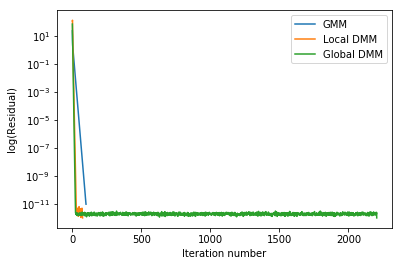

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()